## Final Project

### Analysis of features extarcted from audio data

- link to dataset:

### Motivation and Goals

The goal of this project is to clasdify voice recoridngs as either male of female, based on numerical features extracted from the Mozilla common voice dataset.
The purpose of this project is ...


In [80]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer   
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from playsound import playsound
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from tqdm import tqdm

FULL_RUN=False



## Data Loading

In [27]:
with open("./data/data.csv", "r") as file:
    data_raw = pd.read_csv(file)

data_raw.head()

C:\Users\danie\AppData\Local\Temp\ipykernel_37512\1333520339.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(file)


,path,sentence,age,gender,accents,sentence_domain,mfcc_01_mean,mfcc_02_mean,mfcc_03_mean,mfcc_04_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
0,./clips/common_voice_en_36530280.mp3,"Not long afterward, Diamond met Rick Rubin.",twenties,female_feminine,United States English,NaN,-515.5656,96.9065,-64.7866,17.1681,...,6.4610,6.2823,15.6037,9.0143,4006.9170,1896.3032,0.1312,0.0910,0.0183,0.0215
1,./clips/common_voice_en_36530308.mp3,She was founder and director of the New York C...,twenties,female_feminine,United States English,NaN,-513.5385,107.5431,-24.4517,26.8483,...,6.0342,9.4886,14.7610,9.7149,3864.3149,2129.0798,0.1110,0.0898,0.0133,0.0123
2,./clips/common_voice_en_36530279.mp3,"For all the promise, there was very little ach...",twenties,female_feminine,United States English,NaN,-584.4295,74.4046,-67.4944,31.1713,...,7.5717,7.6878,13.4912,8.2098,4609.3297,1818.5266,0.1630,0.1053,0.0080,0.0093
3,./clips/common_voice_en_36530283.mp3,"He scored in the match, played at Old Trafford.",twenties,female_feminine,United States English,NaN,-460.8448,57.6337,-62.2961,26.1147,...,6.7626,7.4576,9.1393,7.2647,4561.8351,1672.3357,0.1561,0.0911,0.0255,0.0300
4,./clips/common_voice_en_36530309.mp3,"It is located in Emerald Street, Holborn.",twenties,female_feminine,United States English,NaN,-393.3224,81.9662,-43.8744,37.8623,...,6.6980,6.1735,10.9209,7.4521,4314.5123,2034.9706,0.1311,0.0941,0.0392,0.0402


In [28]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199045 entries, 0 to 199044
Data columns (total 94 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   path                       199045 non-null  object 
 1   sentence                   199045 non-null  object 
 2   age                        198228 non-null  object 
 3   gender                     199045 non-null  object 
 4   accents                    173729 non-null  object 
 5   sentence_domain            450 non-null     object 
 6   mfcc_01_mean               199045 non-null  float64
 7   mfcc_02_mean               199045 non-null  float64
 8   mfcc_03_mean               199045 non-null  float64
 9   mfcc_04_mean               199045 non-null  float64
 10  mfcc_05_mean               199045 non-null  float64
 11  mfcc_06_mean               199045 non-null  float64
 12  mfcc_07_mean               199045 non-null  float64
 13  mfcc_08_mean               19

In [29]:
data_raw["age"].unique()

array(['twenties', 'thirties', 'fourties', 'sixties', 'teens', 'fifties',
       nan, 'seventies', 'nineties', 'eighties'], dtype=object)

In [30]:
with open("./data/WORLD-2024.csv", "r") as file:
    world_population_raw = pd.read_csv(file)

def map_to_bin(age_range):
    try:
        lower = int(age_range.split('-')[0])
    except (ValueError, IndexError):
        return None
    return (lower // 10) * 10

world_population = world_population_raw.copy()
world_population['age'] = world_population_raw['Age'].apply(map_to_bin)
world_population['count'] = world_population['M'] + world_population['F']

world_population=world_population.groupby('age', as_index=False)[['M', 'F', 'count']].sum()

print("Global population by age group")
world_population_table= PrettyTable()
world_population_table.field_names = ["Age", "F", "M", "Count"]
for age in world_population["age"].unique():
    female= world_population[world_population["age"] == age]["F"].values[0]
    male= world_population[world_population["age"] == age]["M"].values[0]
    count = world_population[world_population["age"] == age]["count"].values[0]
    world_population_table.add_row([age, female, male, count])
print(world_population_table)

world_population= world_population[(world_population["age"] > 0)&(world_population["age"] < 80)]
world_population['percentage_f'] = world_population['F'] / world_population['count'].sum()
world_population['percentage_m'] = world_population['M'] / world_population['count'].sum()

world_population_table= PrettyTable()
world_population_table.field_names = ["Age", "Count", "Percentage - Female", "Percentage - Male"]
for age in world_population["age"].unique():
    count = world_population[world_population["age"] == age]["count"].values[0]
    percentage_f = world_population[world_population["age"] == age]["percentage_f"].values[0]
    percentage_m = world_population[world_population["age"] == age]["percentage_m"].values[0]
    world_population_table.add_row([age, count, percentage_f, percentage_m])
print(world_population_table)

Global population by age group
+------+-----------+-----------+------------+
| Age  |     F     |     M     |   Count    |
+------+-----------+-----------+------------+
| 0.0  | 647571780 | 683880297 | 1331452077 |
| 10.0 | 646940513 | 689549048 | 1336489561 |
| 20.0 | 591939467 | 627801903 | 1219741370 |
| 30.0 | 583727408 | 612129215 | 1195856623 |
| 40.0 | 499876584 | 511145211 | 1011021795 |
| 50.0 | 444383233 | 438029375 | 882412608  |
| 60.0 | 335349756 | 308707292 | 644057048  |
| 70.0 | 207266969 | 169569804 | 376836773  |
| 80.0 |  84361120 |  55509075 | 139870195  |
| 90.0 |  16467366 |  7180149  |  23647515  |
+------+-----------+-----------+------------+
+------+------------+----------------------+---------------------+
| Age  |   Count    | Percentage - Female  |  Percentage - Male  |
+------+------------+----------------------+---------------------+
| 10.0 | 1336489561 | 0.09704472906340227  | 0.10343624984742138 |
| 20.0 | 1219741370 | 0.08879426167108774  | 0.0941738295

In [31]:
def transform_age(age):
    if age=="teens":
        return 10
    elif age=="twenties":
        return 20
    elif age=="thirties":
        return 30
    elif age=="fourties":
        return 40
    elif age=="fifties":
        return 50
    elif age=="sixties":
        return 60
    elif age=="seventies":
        return 70
    elif isinstance(age, (int, float)):
        return age
    else:
        return None

data_raw["age"] = data_raw["age"].apply(transform_age)
print(f'dropped {data_raw["age"].isnull().sum()} rows')
data_raw = data_raw.dropna(subset=["age"])

# print counts
def generate_age_count_table(df):
    """
    Function to generate a PrettyTable with age counts
    :param df: DataFrame containing an 'age' column
    :return: PrettyTable object
    """
    table = PrettyTable()
    table.field_names = ["Age", "F", "M", "Count"]
    for age in sorted(df["age"].unique()):
        female_count = df[(df["age"] == age) & (df["gender"] == "female_feminine")].shape[0]
        male_count = df[(df["age"] == age) & (df["gender"] =="male_masculine")].shape[0]
        count = df[df["age"] == age].shape[0]
        table.add_row([age,female_count, male_count, count])
    return table

# Generate and print the table
table = generate_age_count_table(data_raw)
print(table)

dropped 995 rows
+------+-------+-------+-------+
| Age  |   F   |   M   | Count |
+------+-------+-------+-------+
| 10.0 |  5812 |  4580 | 10392 |
| 20.0 | 45060 | 20368 | 65428 |
| 30.0 | 16730 | 37185 | 53915 |
| 40.0 | 21451 |  5818 | 27269 |
| 50.0 |  3723 | 16144 | 19867 |
| 60.0 |  4071 | 16153 | 20224 |
| 70.0 |  137  |  818  |  955  |
+------+-------+-------+-------+


In [32]:
def histograms(data):
    """
    Function to plot histograms of the dataframe
    :param data: DataFrame
    :return: None
    """
    data.hist(figsize=(20, 20), bins=50, color='black')
    plt.suptitle('Histograms (50 bins) of all features', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
if FULL_RUN:   
    histograms(data_raw)

In [33]:
# histograms by gender
def histogram_by_gender(feature):
    
    female_feminine = data_raw['gender'] == 'female_feminine'
    feature_female = feature[female_feminine]
    
    male_masculine = data_raw['gender'] == 'male_masculine'
    feature_male = feature[male_masculine]
    
    plt.figure(figsize=(10, 5))
    plt.hist(feature_female, bins=50, color='pink', alpha=0.5)
    plt.hist(feature_male, bins=50, color='blue', alpha=0.5)
    plt.title(f'Histogram of {feature.columns[0]}')
    plt.show()

if FULL_RUN: 
    histogram_by_gender(data_raw[['spec_bandwidth_mean']])
    histogram_by_gender(data_raw[['spec_contrast_band_1_mean']])

        

In [34]:
col_to_log_transform = ['spec_contrast_band_7_mean', 'spec_contrast_band_7_std', 'rmse_mean', 'rmse_std']

In [35]:
# drop sentence_domain
try:
    data_raw = data_raw.drop(columns=["sentence_domain"])
except:
    print("Column sentence_domain dropped")

In [36]:
# First histogram
if FULL_RUN:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    np.log(data_raw['rmse_mean'] + 1e-10).hist(bins=200, ax=axes[0], color='black')
    # data_raw['rmse_mean'].hist(bins=200, ax=axes[0], color='black')
    axes[0].set_title('Before Dropping Quiet Audio Files')

# Dropping quiet audio files
bool_mask_quiet = data_raw["rmse_mean"] < 0.01
data_clean = data_raw[~bool_mask_quiet]

# Second histogram
if FULL_RUN:
    np.log(data_clean['rmse_mean'] + 1e-10).hist(bins=200, ax=axes[1], color='black')
    # data_raw['rmse_mean'].hist(bins=200, ax=axes[1], color='black')
    axes[1].set_title('After Dropping Quiet Audio Files')

    plt.suptitle('Logarithm of rmse_mean', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


In [37]:
""" #Undersample based on the demographic data
data_reduced = pd.DataFrame(columns=data_raw.columns)
for age in demographically_based_count["age"].unique():
    
    count_f = demographically_based_count[demographically_based_count["age"] == age]["count_f"].values[0].astype(int)
    count_m = demographically_based_count[demographically_based_count["age"] == age]["count_m"].values[0].astype(int)
    age_group_f = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="female_feminine")]
    age_group_m = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="male_masculine")]
    if len(age_group_f) > count_f:
        age_group_f = age_group_f.sample(n=count_f, random_state=27)
    if len(age_group_m) > count_m:
        age_group_m = age_group_m.sample(n=count_m, random_state=27)
    data_reduced = pd.concat([data_reduced, age_group_f, age_group_m], ignore_index=True)
data_reduced = data_reduced.sample(frac=1, random_state=27).reset_index(drop=True)


# Undersample the data
#data_raw = data_raw.groupby("age").apply(lambda x: x.sample(n=min(len(x)), random_state=27)).reset_index(drop=True)

table = generate_age_count_table(data_reduced)
print(table) """

' #Undersample based on the demographic data\ndata_reduced = pd.DataFrame(columns=data_raw.columns)\nfor age in demographically_based_count["age"].unique():\n    \n    count_f = demographically_based_count[demographically_based_count["age"] == age]["count_f"].values[0].astype(int)\n    count_m = demographically_based_count[demographically_based_count["age"] == age]["count_m"].values[0].astype(int)\n    age_group_f = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="female_feminine")]\n    age_group_m = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="male_masculine")]\n    if len(age_group_f) > count_f:\n        age_group_f = age_group_f.sample(n=count_f, random_state=27)\n    if len(age_group_m) > count_m:\n        age_group_m = age_group_m.sample(n=count_m, random_state=27)\n    data_reduced = pd.concat([data_reduced, age_group_f, age_group_m], ignore_index=True)\ndata_reduced = data_reduced.sample(frac=1, random_state=27).reset_index(drop=True)\n\n\n# Undersample 

In [38]:
#Legacy weighting of the data
def calculate_weights(data_clean): 
    weights_df = world_population.melt(
        id_vars="age", 
        value_vars=["F", "M"], 
        var_name="gender", 
        value_name="population_count"
    )

    # Map gender to full names
    weights_df["gender"] = weights_df["gender"].map(
        {"F": "female_feminine", "M": "male_masculine"}
    )

    # Add percentage columns back to the melted DataFrame
    weights_df["percentage"] = weights_df.apply(
        lambda row: row["population_count"] / weights_df["population_count"].sum(), axis=1
    )

    # STEP 2: Compute sample proportions from your dataset
    sample_counts = data_clean.groupby(["age","gender"]).size().reset_index(name="sample_count")
    total_sample_count = len(data_clean)
    sample_counts["sample_proportion"] = sample_counts["sample_count"] / total_sample_count

    # STEP 3: Merge and calculate weights
    weights_df = pd.merge(
        weights_df, 
        sample_counts, 
        on=["age", "gender"], 
        how="inner"
    )

    def adapted_sigmoid_scaling(w_raw):
        if w_raw < 1:
            return w_raw
        else:
            return np.log1p(w_raw)
    
    # Calculate sample weights
    weights_df["sample_weight"] = weights_df["percentage"] / weights_df["sample_proportion"]
    weights_df["log_sample_weight"] = weights_df["sample_weight"].apply(adapted_sigmoid_scaling)
    return weights_df


#Output to verify proportions and weights
weights_initial = calculate_weights(data_clean)
pd.set_option('display.float_format', lambda x: f'{x:0.4f}')
print("\n=== Age × Gender Weight Summary ===")
print(weights_initial[["age", "gender", "percentage", "sample_proportion", "sample_weight"]].sort_values(by=["age", "gender"]).reset_index(drop=True))


=== Age × Gender Weight Summary ===
       age           gender  percentage  sample_proportion  sample_weight
0  10.0000  female_feminine      0.0970             0.0299         3.2487
1  10.0000   male_masculine      0.1034             0.0227         4.5493
2  20.0000  female_feminine      0.0888             0.2063         0.4304
3  20.0000   male_masculine      0.0942             0.1038         0.9076
4  30.0000  female_feminine      0.0876             0.0883         0.9916
5  30.0000   male_masculine      0.0918             0.1962         0.4681
6  40.0000  female_feminine      0.0750             0.1133         0.6617
7  40.0000   male_masculine      0.0767             0.0300         2.5527
8  50.0000  female_feminine      0.0667             0.0135         4.9289
9  50.0000   male_masculine      0.0657             0.0851         0.7725
10 60.0000  female_feminine      0.0503             0.0215         2.3360
11 60.0000   male_masculine      0.0463             0.0844         0.5489
1

In [39]:
def constrained_undersample(
    data_clean,
    world_population,
    total_samples=100_000,
    seed=27,
    redistribute_shortfall=True
):
    np.random.seed(seed)

    # Prepare world_population long format
    pop_f = world_population[['age', 'percentage_f']].rename(columns={'percentage_f': 'percentage'})
    pop_f['gender'] = 'female_feminine'
    pop_m = world_population[['age', 'percentage_m']].rename(columns={'percentage_m': 'percentage'})
    pop_m['gender'] = 'male_masculine'
    pop_long = pd.concat([pop_f, pop_m], ignore_index=True)

    # Normalize percentages to sum to 1 (in case of small drift)
    pop_long['percentage'] = pop_long['percentage'] / pop_long['percentage'].sum()

    # Compute target counts per stratum
    pop_long['target_count'] = (pop_long['percentage'] * total_samples).round().astype(int)

    # Actual counts in your data_clean
    actual_counts = data_clean.groupby(['age', 'gender']).size().reset_index(name='available_count')

    # Merge target + available
    strata = pop_long.merge(actual_counts, on=['age', 'gender'], how='left').fillna({'available_count': 0})
    strata['available_count'] = strata['available_count'].astype(int)

    # Allocate samples — take min(target, available)
    strata['samples_taken'] = strata[['target_count', 'available_count']].min(axis=1)

    total_taken = strata['samples_taken'].sum()
    shortfall = total_samples - total_taken

    strata['final_sample_count'] = strata['samples_taken']  # Default if no redistribution

    # Redistribute shortfall if requested
    if redistribute_shortfall and shortfall > 0:
        strata['surplus'] = strata['available_count'] - strata['samples_taken']
        strata['can_take_more'] = strata['surplus'] > 0

        if strata['can_take_more'].any():
            surplus_total = strata.loc[strata['can_take_more'], 'surplus'].sum()
            strata['extra_allocation'] = 0

            # Proportional allocation of shortfall
            strata.loc[strata['can_take_more'], 'extra_allocation'] = (
                (strata['surplus'] / surplus_total) * shortfall
            ).round().astype(int)

            # Ensure no over-allocation
            strata['final_sample_count'] = strata['samples_taken'] + strata['extra_allocation']
            strata['final_sample_count'] = strata[['final_sample_count', 'available_count']].min(axis=1)

 
    # Sample from data_clean
    sampled_dfs = []
    for _, row in strata.iterrows():
        mask = (data_clean['age'] == row['age']) & (data_clean['gender'] == row['gender'])
        df_group = data_clean[mask]
        n_samples = row['final_sample_count']
        if n_samples > 0 and not df_group.empty:
            sampled_group = df_group.sample(n=n_samples, random_state=seed)
            sampled_dfs.append(sampled_group)

    if sampled_dfs:
        data_reduced = pd.concat(sampled_dfs, ignore_index=True)
    else:
        # Return empty df with same columns as data_clean
        data_reduced = data_clean.iloc[0:0].copy()

    print(strata[['age', 'gender', 'available_count', 'target_count', 'final_sample_count']])
    print(f"Total samples taken: {data_reduced.shape[0]}")
    print(f"Male to Female ratio: {data_reduced.groupby("gender").size().to_dict()}")

    return data_reduced


data_reduced = constrained_undersample(
    data_clean,
    world_population,
    total_samples=100_000,
    redistribute_shortfall=False,
)


       age           gender  available_count  target_count  final_sample_count
0  10.0000  female_feminine             5639          9704                5639
1  20.0000  female_feminine            38948          8879                8879
2  30.0000  female_feminine            16669          8756                8756
3  40.0000  female_feminine            21391          7498                7498
4  50.0000  female_feminine             2553          6666                2553
5  60.0000  female_feminine             4065          5030                4065
6  70.0000  female_feminine              133          3109                 133
7  10.0000   male_masculine             4292         10344                4292
8  20.0000   male_masculine            19587          9417                9417
9  30.0000   male_masculine            37028          9182                9182
10 40.0000   male_masculine             5670          7667                5670
11 50.0000   male_masculine            16056        

In [40]:
# Data frames 
y= data_reduced[["gender", "age"]]
X= data_reduced.drop(columns=["gender", "age", "accents"])

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=27)

# Perform the split
for train_index, temp_index in sss.split(X,  y['age'].astype(str) + "-" + y['gender']):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_temp = X.iloc[temp_index]
    y_temp = y.iloc[temp_index]

# Further split the temporary set into validation and test sets
sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=27)
for test_index, val_index in sss_temp.split(X_temp, y_temp['age'].astype(str) + "-" + y_temp['gender']):
    X_test = X_temp.iloc[test_index]
    y_test = y_temp.iloc[test_index]
    X_val = X_temp.iloc[val_index]
    y_val = y_temp.iloc[val_index]

# Df only for EDA
df_eda = X_train.copy().drop(columns=["path", "sentence"])
df_eda['age'] = y_train["age"]
df_eda['gender'] = y_train['gender']
df_eda['age-gender'] = y_train["age"].astype(int).astype(str) + "-" + y_train["gender"].str[0]
df_eda_cat = df_eda.select_dtypes(include=['object'])
df_eda_num = df_eda.select_dtypes(include=['number'])

# Drop columns that are not needed
X_train = X_train.drop(columns=["path", "sentence"])
X_test = X_test.drop(columns=["path", "sentence"])
X_val = X_val.drop(columns=["path", "sentence"])

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)



X_train shape:  (54670, 88)
X_val shape:  (11716, 88)
X_test shape:  (11715, 88)


In [41]:
print(generate_age_count_table(y_train))
print(generate_age_count_table(y_val))
print(generate_age_count_table(y_test))

+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 3947 | 3004 |  6951 |
| 20.0 | 6215 | 6592 | 12807 |
| 30.0 | 6129 | 6427 | 12556 |
| 40.0 | 5249 | 3969 |  9218 |
| 50.0 | 1787 | 4600 |  6387 |
| 60.0 | 2845 | 3242 |  6087 |
| 70.0 |  93  | 571  |  664  |
+------+------+------+-------+
+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 846  | 644  |  1490 |
| 20.0 | 1332 | 1413 |  2745 |
| 30.0 | 1314 | 1378 |  2692 |
| 40.0 | 1125 | 850  |  1975 |
| 50.0 | 383  | 985  |  1368 |
| 60.0 | 610  | 694  |  1304 |
| 70.0 |  20  | 122  |  142  |
+------+------+------+-------+
+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 846  | 644  |  1490 |
| 20.0 | 1332 | 1412 |  2744 |
| 30.0 | 1313 | 1377 |  2690 |
| 40.0 | 1124 | 851  |  1975 |
| 50.0 | 383  | 986  |  1369 |
| 60.0 | 610  | 695  |  1305 |
| 70.0 |  20  | 122  |  142  |
+------+

## EDA

In [42]:
if FULL_RUN:
    df_eda.describe()

In [43]:
if FULL_RUN:
    df_eda.info()
    print(df_eda['gender'].value_counts())

In [44]:
# comparing the means of the features using groupbys

def table_grouped_by(df, group_by_col):
    grouped_by_y = df.groupby(group_by_col).mean().T
    table = PrettyTable()
    table.field_names = ["Feature"]+list(grouped_by_y.columns)
    for feature, values in zip(grouped_by_y.index, grouped_by_y.values):
        table.add_row([feature] + values.tolist())
    table.align = "r"
    table.align["Feature"] = "l"
    table.title = "Grouped by " + group_by_col.name
    print(table)

if FULL_RUN:    
    table_grouped_by(df_eda_num, df_eda['gender'])
    table_grouped_by(df_eda_num, df_eda['age'])
    table_grouped_by(df_eda_num, df_eda['age-gender'])

In [45]:
# Correlation Matrix (save to zoom in)

def generate_correlation_matrix(df):
    plt.figure(figsize=(50, 50))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

if FULL_RUN:    
    generate_correlation_matrix(df_eda_num)

In [46]:
# scatter plots
def scatter_plot(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=df[['age', 'gender']].apply(tuple, axis=1), alpha=0.8)
    plt.title(f'Scatter plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

if FULL_RUN:
    # mfcc 
    # ....mfcc not multimodal
    scatter_plot(df_eda, 'mfcc_01_mean', 'mfcc_07_mean')
    scatter_plot(df_eda, 'mfcc_01_mean', 'spec_centroid_mean')
    # ....mfcc bimodal
    scatter_plot(df_eda, 'mfcc_02_mean', 'mfcc_04_mean')
    scatter_plot(df_eda, 'mfcc_02_mean', 'zcr_mean')


    # chroma differences in distances
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_02_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_05_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_11_mean')

    # spectral
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_bandwidth_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_1_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_4_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_7_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'zcr_mean')

    # temporal
    scatter_plot(df_eda, 'zcr_mean', 'rmse_mean')

## Data Preprocessing

In [47]:
# Log transformation
def use_log(data, scale_by_min=False):
    assert np.min(data) >= 0, 'data contains negative or zero values at log transform'
    transformed = np.log(data)
    return transformed

# Defining Transformers
scl = StandardScaler()
log = FunctionTransformer(func=use_log, validate=False, kw_args={'scale_by_min': True}, feature_names_out='one-to-one')

# Defining Models
pca = PCA(n_components=0.95) # try differnet n_components
lda = LinearDiscriminantAnalysis()

# Pipelines
pipeline_log = Pipeline(steps=[
    ('log', log),
    ('scaler', scl)
])

pipeline_num = Pipeline(steps=[
    ('scaler', scl)
])

# Column selection
preprocessing = ColumnTransformer([
('log', pipeline_log, col_to_log_transform),
], remainder=pipeline_num)

preprocessing_pca = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('pca', pca)
    ]
)
preprocessing_lda = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('lda', lda)
    ]
)


In [48]:
if FULL_RUN:
    # (EDA Step) checking results of PCA and LDA
    preprocessing.fit(X_train)
    preprocessing_pca.fit(X_train)
    preprocessing_lda.fit(X_train, y_train['age'])

In [49]:
if FULL_RUN:
    # Visualize PCA
    x_train_pca = preprocessing_pca.fit_transform(X_train)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_train_pca[:, 0], y=x_train_pca[:, 1], hue=y_train["age"], palette="hls", alpha=0.6)
    plt.title('Scatterplot of PC1 vs PC2')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Age')
    plt.show()

In [50]:
# LDA
if FULL_RUN:
    lda = preprocessing_lda.named_steps['lda']

    coefficients = lda.coef_[0]
    imp_lda = pd.DataFrame(coefficients, index=X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

    table = PrettyTable()
    table.field_names = ["Feature", "Coefficient"]
    for row in zip(imp_lda.index, imp_lda['Coefficient']):
        feature = str(row[0])
        coef = float(row[1])
        table.add_row([feature, coef])
    print(table)


In [51]:
if FULL_RUN:
    x_train_lda = preprocessing_lda.transform(X_train)
    print(x_train_lda.shape)

In [52]:
preprocessed = preprocessing.fit_transform(X_train)
features = preprocessing.get_feature_names_out()

In [53]:
if FULL_RUN:
    df = pd.DataFrame(preprocessed, columns=features)
    df.head()
    histograms(df)

## Fitting Models

In [54]:
def evaluate_models(y_true, y_pred_dict, figsize=(12, 8), expanded=True, label=None):
    """
    Function to evaluate multiple models and compare their performance
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_dict : dict
        Dictionary of model predictions where keys are model names and values are predicted labels
        Example: {'Model1': y_pred1, 'Model2': y_pred2}
    figsize : tuple, optional
        Figure size for the visualizations, default is (12, 8)
        
    Returns:
    --------
    metrics_df : pandas DataFrame
        DataFrame containing performance metrics for all models
    """

    
    # Initialize a dictionary to store metrics
    metrics = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': []
    }
    
    if expanded:
    # Set up the plot for confusion matrices
        n_models = len(y_pred_dict)
        fig, axes = plt.subplots(1, n_models, figsize=figsize)
        if n_models == 1:
            axes = [axes]  # Convert to list for consistent indexing
    
    # Evaluate each model
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        # Print classification report
        print(f"\n===== {model_name}: {label} =====")
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        
        # Store metrics
        metrics['Model'].append(model_name)
        metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
        
        # Handle binary and multi-class cases for precision, recall, and f1
        if len(np.unique(y_true)) == 2:
            # Binary classification
            metrics['Precision'].append(precision_score(y_true, y_pred, average='binary'))
            metrics['Recall'].append(recall_score(y_true, y_pred, average='binary'))
            metrics['F1-score'].append(f1_score(y_true, y_pred, average='binary'))
        else:
            # Multi-class classification
            metrics['Precision'].append(precision_score(y_true, y_pred, average='weighted'))
            metrics['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
            metrics['F1-score'].append(f1_score(y_true, y_pred, average='weighted'))
        
        if expanded:
            # Plot confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Confusion Matrix - {model_name}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
    
    if expanded:
        plt.tight_layout()
        plt.show()
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    if expanded:
        # Plot metrics comparison
        plt.figure(figsize=(10, 6))
        metrics_df_plot = metrics_df.set_index('Model')
        metrics_df_plot.plot(kind='bar', figsize=(10, 6))
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    return metrics_df

In [55]:
def fit_pipeline_predict_evaluate(model_class, model_name, weights_df=None,weight_attribute_name=None,PCA=False, LDA=False):
    """
    Function to fit a pipeline, make predictions, and evaluate the model with optional weights.
    """
    # Create fresh instances of the model
    model = clone(model_class)
    
    # Build pipelines
    pipeline = make_pipeline(preprocessing, model)
    
    # Merge weights into the training data if provided
    if weights_df is not None:
        y_train_with_weights = pd.merge(
            y_train,
            weights_df[["age", "gender", weight_attribute_name]],
            on=["age", "gender"],
            how="left"
        )
        sample_weights = y_train_with_weights[weight_attribute_name].values
    else:
        sample_weights = None
    
    # Fit the model
    fit_params = {f"{pipeline.steps[-1][0]}__sample_weight": sample_weights} if sample_weights is not None else {}
    pipeline.fit(X_train, y_train['age'], **fit_params)
      
    # Predict on training set
    prd_train = pipeline.predict(X_train)
  
    # Predict on validation set
    prd_val = pipeline.predict(X_val)

    # Same Pipeline for PCA and LDA if selected
    if PCA:
        model_pca = clone(model_class)
        pipeline_pca = make_pipeline(preprocessing_pca, model_pca)
        pipeline_pca.fit(X_train, y_train['age'], **fit_params)
        prd_train_pca = pipeline_pca.predict(X_train)
        prd_val_pca = pipeline_pca.predict(X_val)

    if LDA:
        model_lda = clone(model_class)
        pipeline_lda = make_pipeline(preprocessing_lda, model_lda)
        pipeline_lda.fit(X_train, y_train['age'], **fit_params)
        prd_train_lda = pipeline_lda.predict(X_train)
        prd_val_lda = pipeline_lda.predict(X_val)

    if PCA and LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
            f'{model_name}_lda': prd_val_lda,
        }
    elif PCA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
        }
    elif LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_lda': prd_val_lda,
        }
    else:
        evaluate_train = {
            f'{model_name}': prd_train,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
        }
        
    # Evaluate on training predictions
    print(f"Evaluating {model_name} on training set...")
    evaluate_models(y_train['age'], evaluate_train, (12, 8), False, "Training Set")

    # Evaluate on validation predictions
    print(f"Evaluating {model_name} on validation set...")
    return evaluate_models(y_val['age'], evaluate_val, (12, 8), True, "Validation Set")

Evaluating Logistic Regression on training set...

===== Logistic Regression: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.54      0.44      0.49      6951
        20.0       0.57      0.59      0.58     12807
        30.0       0.71      0.78      0.74     12556
        40.0       0.72      0.71      0.72      9218
        50.0       0.75      0.70      0.72      6387
        60.0       0.79      0.80      0.80      6087
        70.0       0.90      0.89      0.89       664

    accuracy                           0.68     54670
   macro avg       0.71      0.70      0.71     54670
weighted avg       0.67      0.68      0.67     54670

Evaluating Logistic Regression on validation set...

===== Logistic Regression: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.56      0.45      0.50      1490
        20.0       0.59      0.59      0.59      2

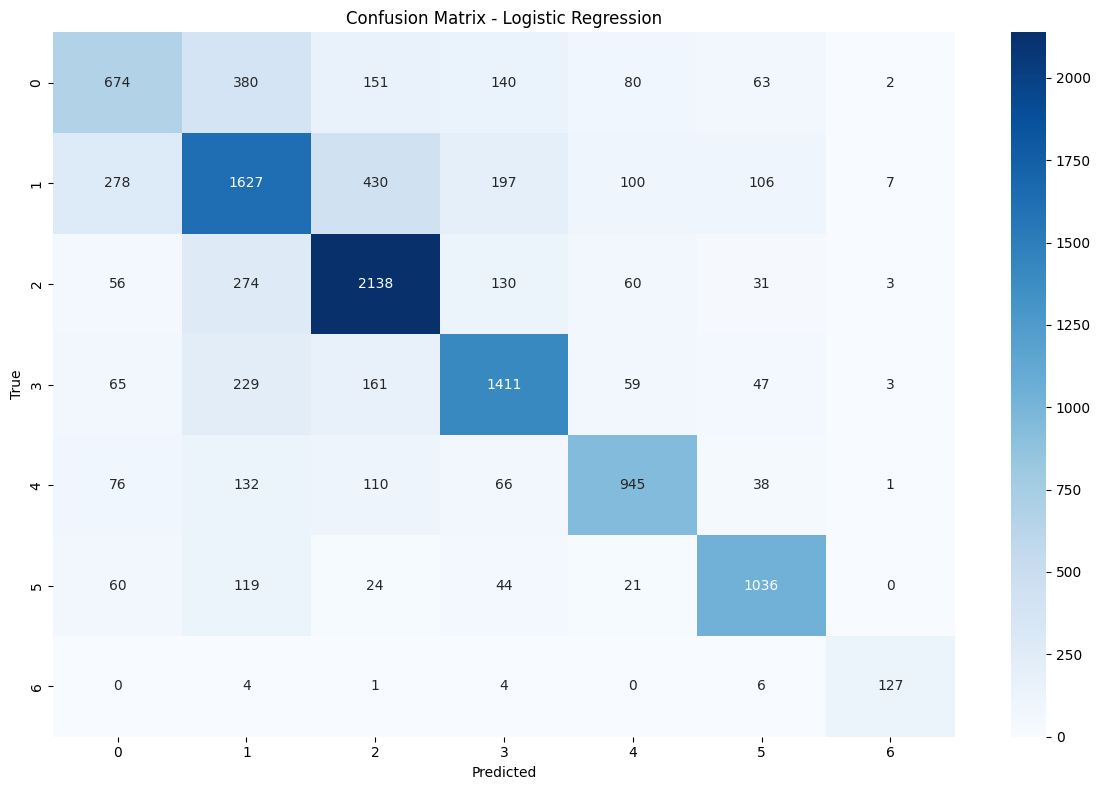

<Figure size 1000x600 with 0 Axes>

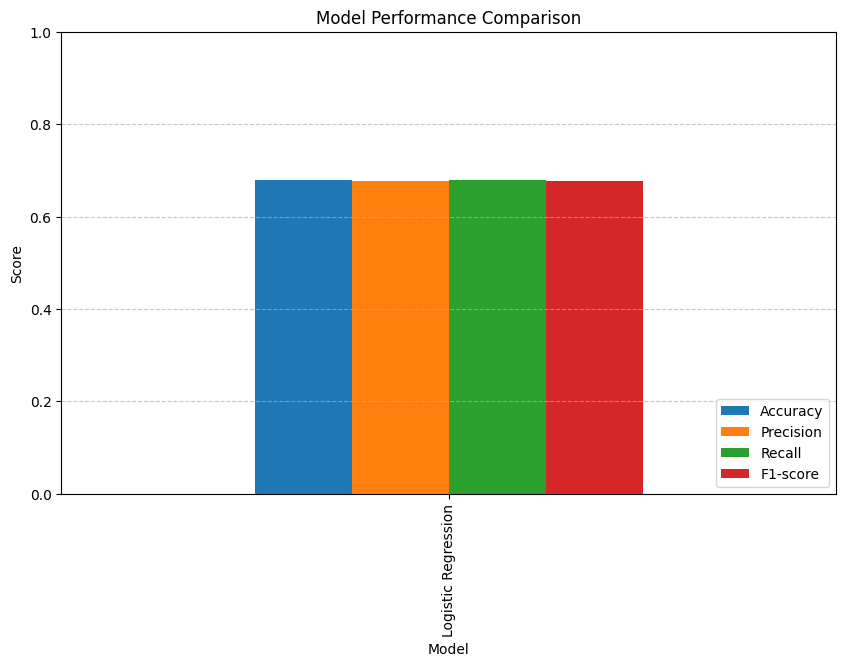

In [56]:
logistic_metrics=fit_pipeline_predict_evaluate(LogisticRegression(solver='lbfgs', max_iter=300, C=1.0, random_state=27), "Logistic Regression")

Evaluating Random Forest Classifier on training set...

===== Random Forest Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       1.00      1.00      1.00      6951
        20.0       1.00      1.00      1.00     12807
        30.0       1.00      1.00      1.00     12556
        40.0       1.00      1.00      1.00      9218
        50.0       1.00      1.00      1.00      6387
        60.0       1.00      1.00      1.00      6087
        70.0       1.00      1.00      1.00       664

    accuracy                           1.00     54670
   macro avg       1.00      1.00      1.00     54670
weighted avg       1.00      1.00      1.00     54670

Evaluating Random Forest Classifier on validation set...

===== Random Forest Classifier: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.88      0.81      0.85      1490
        20.0       0.77      0

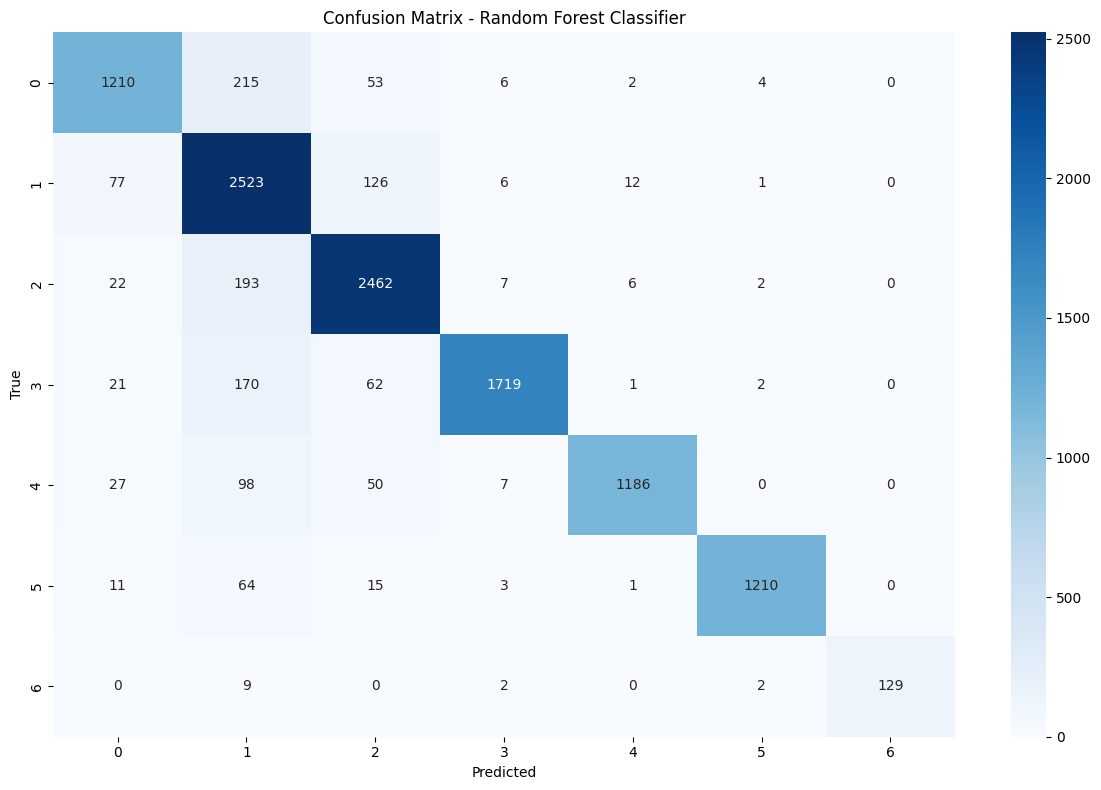

<Figure size 1000x600 with 0 Axes>

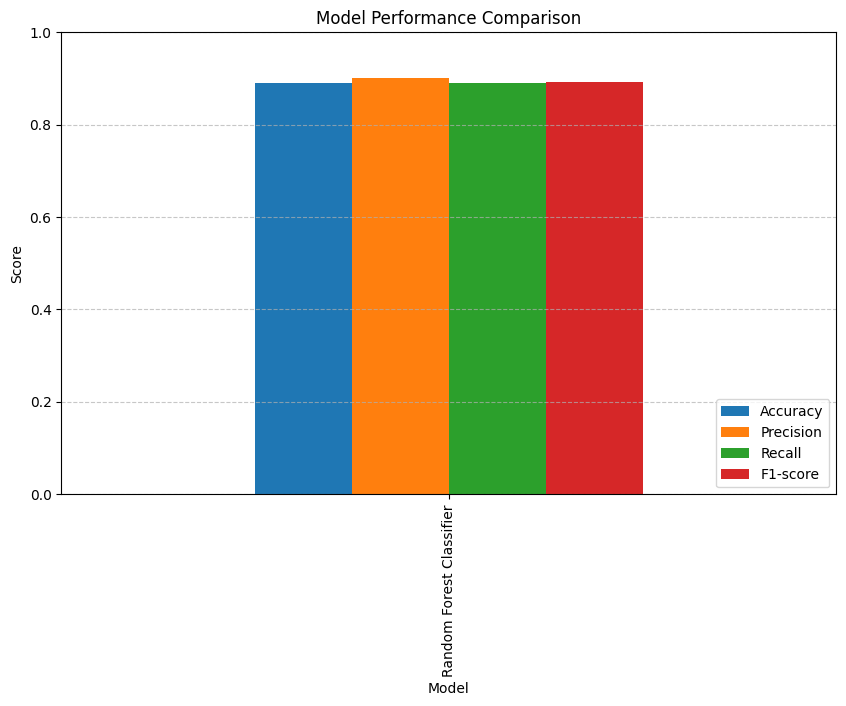

In [58]:
rand_forest_metrics=fit_pipeline_predict_evaluate(RandomForestClassifier(n_estimators=100, random_state=27), "Random Forest Classifier")

Evaluating SVC on training set...

===== SVC: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.54      0.38      0.44      6951
        20.0       0.58      0.55      0.56     12807
        30.0       0.66      0.81      0.72     12556
        40.0       0.70      0.70      0.70      9218
        50.0       0.73      0.68      0.70      6387
        60.0       0.76      0.81      0.78      6087
        70.0       0.88      0.89      0.89       664

    accuracy                           0.66     54670
   macro avg       0.69      0.69      0.69     54670
weighted avg       0.65      0.66      0.65     54670

Evaluating SVC on validation set...

===== SVC: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.55      0.38      0.45      1490
        20.0       0.59      0.55      0.57      2745
        30.0       0.65      0.81      0.72      2692
      

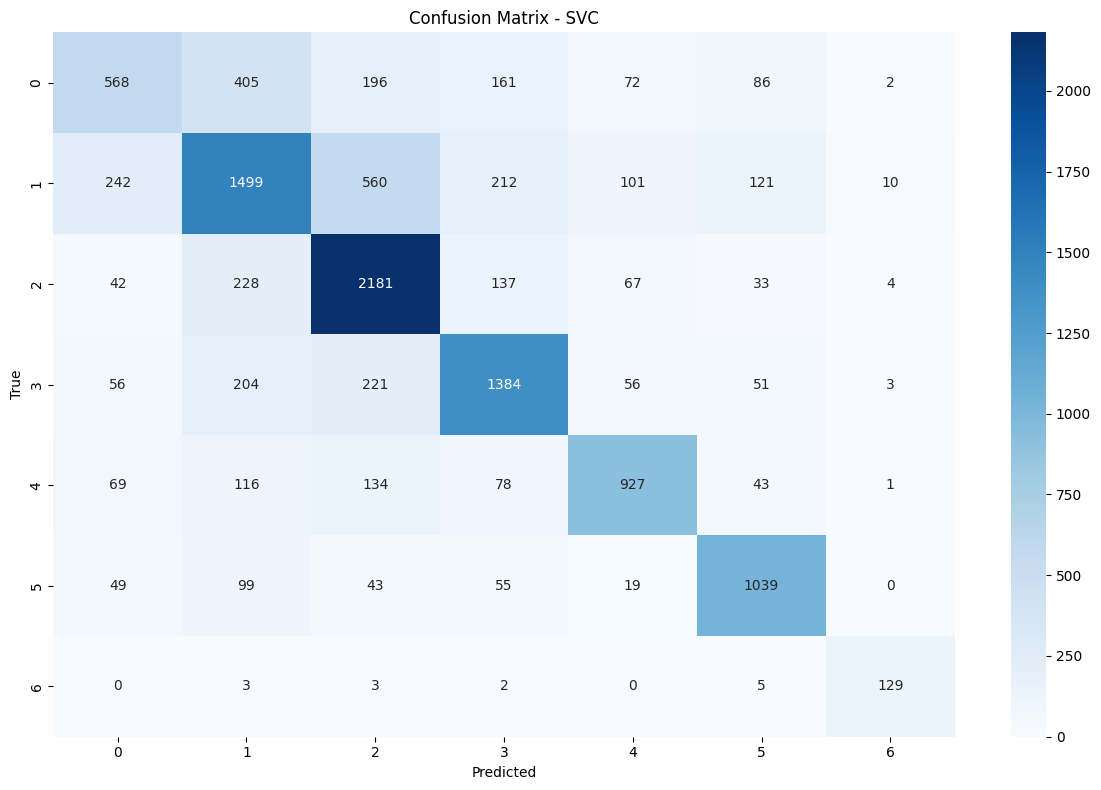

<Figure size 1000x600 with 0 Axes>

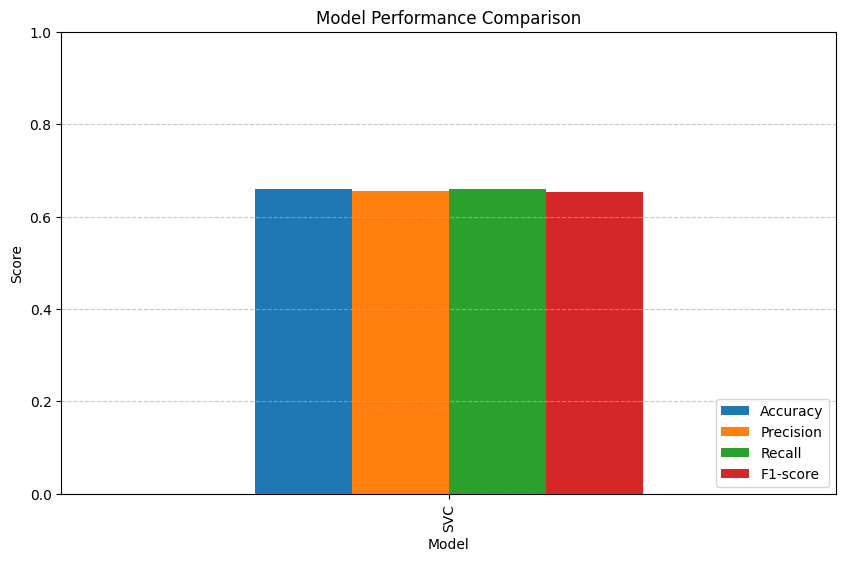

In [66]:
svc_metrics=fit_pipeline_predict_evaluate(LinearSVC(random_state=27, max_iter=10000), "SVC")

Evaluating KNeighbors Classifier on training set...

===== KNeighbors Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.93      0.94      0.94      6951
        20.0       0.96      0.91      0.93     12807
        30.0       0.94      0.97      0.95     12556
        40.0       0.97      0.97      0.97      9218
        50.0       0.97      0.97      0.97      6387
        60.0       0.97      0.99      0.98      6087
        70.0       0.99      0.99      0.99       664

    accuracy                           0.96     54670
   macro avg       0.96      0.96      0.96     54670
weighted avg       0.96      0.96      0.96     54670

Evaluating KNeighbors Classifier on validation set...

===== KNeighbors Classifier: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.91      0.94      0.92      1490
        20.0       0.94      0.89      0.9

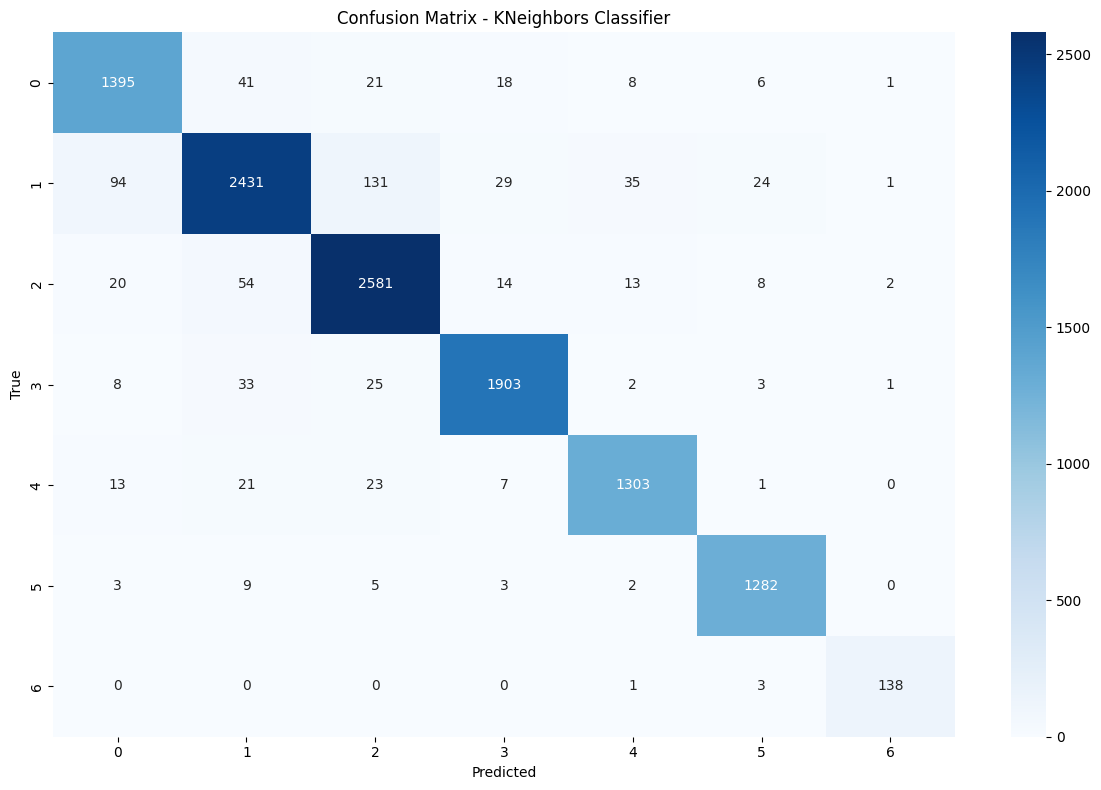

<Figure size 1000x600 with 0 Axes>

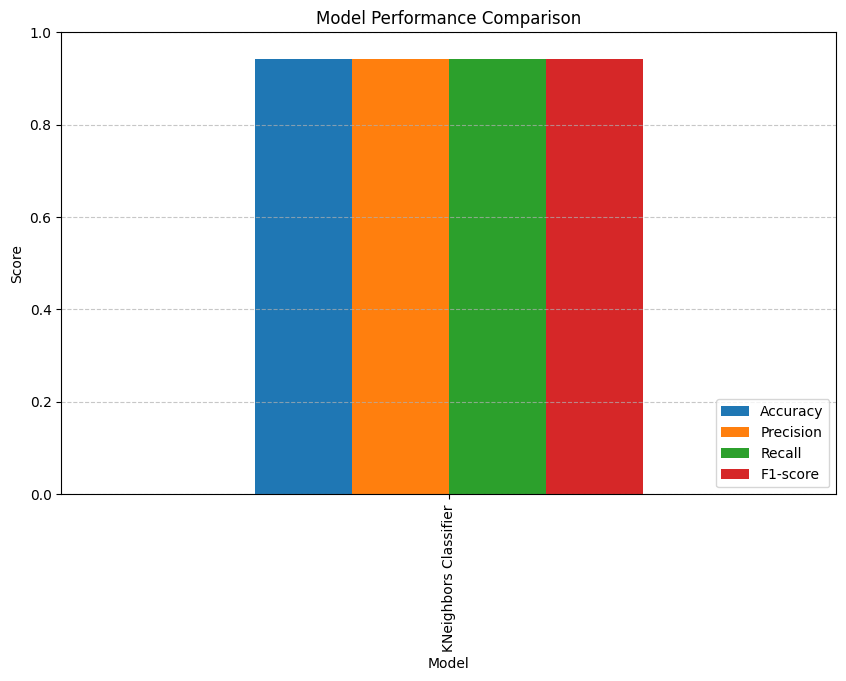

In [67]:
kneighbors_metrics=fit_pipeline_predict_evaluate(KNeighborsClassifier(n_neighbors=11), "KNeighbors Classifier")

Evaluating MLP Classifier on training set...

===== MLP Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.98      0.95      0.97      6951
        20.0       0.98      0.96      0.97     12807
        30.0       0.97      0.99      0.98     12556
        40.0       0.97      0.99      0.98      9218
        50.0       0.98      0.99      0.99      6387
        60.0       0.99      0.99      0.99      6087
        70.0       0.99      0.99      0.99       664

    accuracy                           0.98     54670
   macro avg       0.98      0.98      0.98     54670
weighted avg       0.98      0.98      0.98     54670

Evaluating MLP Classifier on validation set...

===== MLP Classifier: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.87      0.84      0.86      1490
        20.0       0.89      0.83      0.86      2745
        30.0    

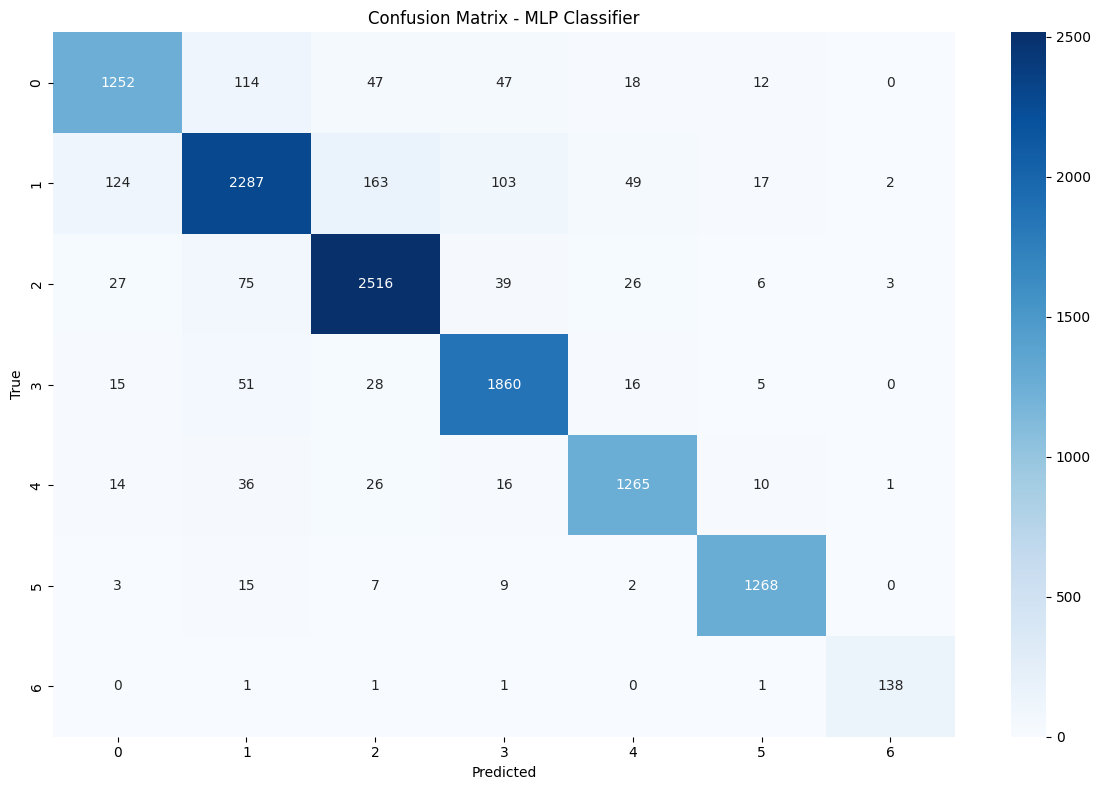

<Figure size 1000x600 with 0 Axes>

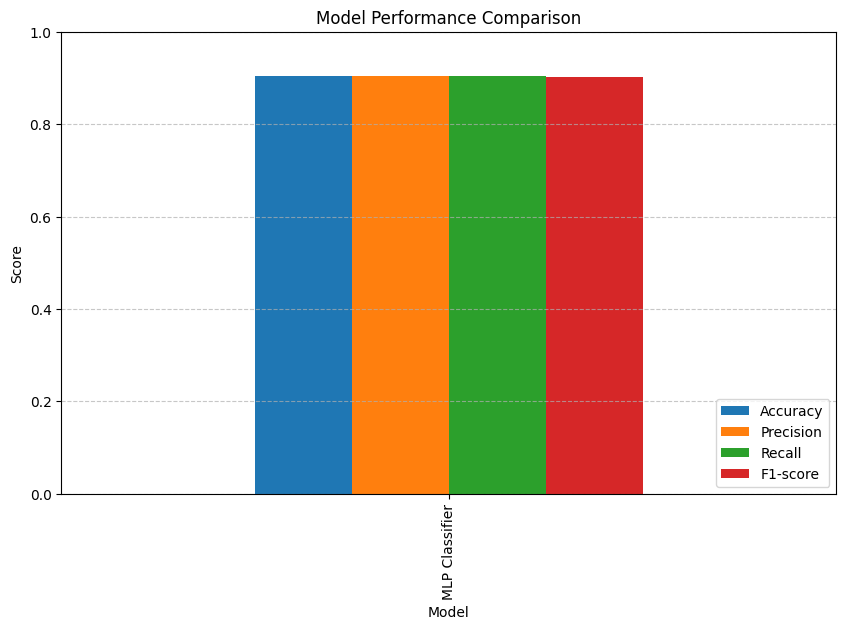

' mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64, 32),\n              alpha=0.001,\n              learning_rate_init=0.0005,\n              max_iter=2000,\n              batch_size=32,\n              early_stopping=True,\n              validation_fraction=0.1,\n              random_state=27,\n              solver=\'adam\')\n, "MLP Classifier") '

In [68]:
#mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000, random_state=27, batch_size=32, learning_rate='adaptive', learning_rate_init=0.0003), "MLP Classifier")

""" mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(64, 64),
              max_iter=1000,
              random_state=27,
              batch_size=32,
              learning_rate='adaptive',
              learning_rate_init=0.001,
              alpha=0.0001),
 "MLP Classifier") """

""" mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64),  
              max_iter=1000,
              random_state=27,
              batch_size=64,  
              learning_rate='adaptive',
              learning_rate_init=0.0005,  
              alpha=0.001, 
              early_stopping=True,
              validation_fraction=0.1),
 "MLP Classifier") """


mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64, 32),
              max_iter=2000,
              random_state=27,
              batch_size=32,
              learning_rate='adaptive',
              learning_rate_init=0.0005,
              alpha=0.001,
              early_stopping=True,
              validation_fraction=0.1)
, "MLP Classifier")

""" mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64, 32),
              alpha=0.001,
              learning_rate_init=0.0005,
              max_iter=2000,
              batch_size=32,
              early_stopping=True,
              validation_fraction=0.1,
              random_state=27,
              solver='adam')
, "MLP Classifier") """

Evaluating Gradient Boosting Classifier on training set...

===== Gradient Boosting Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.95      0.92      0.94      6951
        20.0       0.92      0.95      0.94     12807
        30.0       0.95      0.96      0.96     12556
        40.0       0.99      0.97      0.98      9218
        50.0       0.99      0.97      0.98      6387
        60.0       1.00      0.99      1.00      6087
        70.0       1.00      0.99      1.00       664

    accuracy                           0.96     54670
   macro avg       0.97      0.97      0.97     54670
weighted avg       0.96      0.96      0.96     54670

Evaluating Gradient Boosting Classifier on validation set...

===== Gradient Boosting Classifier: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.83      0.80      0.82      1490
        20.0  

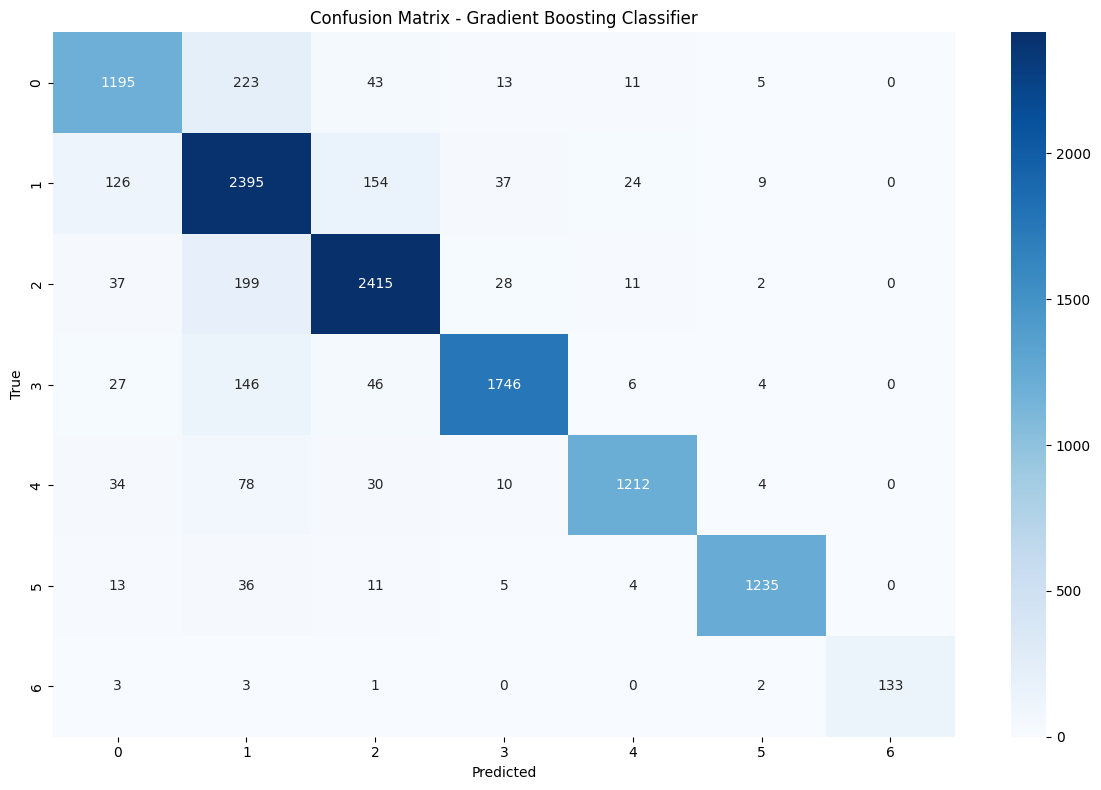

<Figure size 1000x600 with 0 Axes>

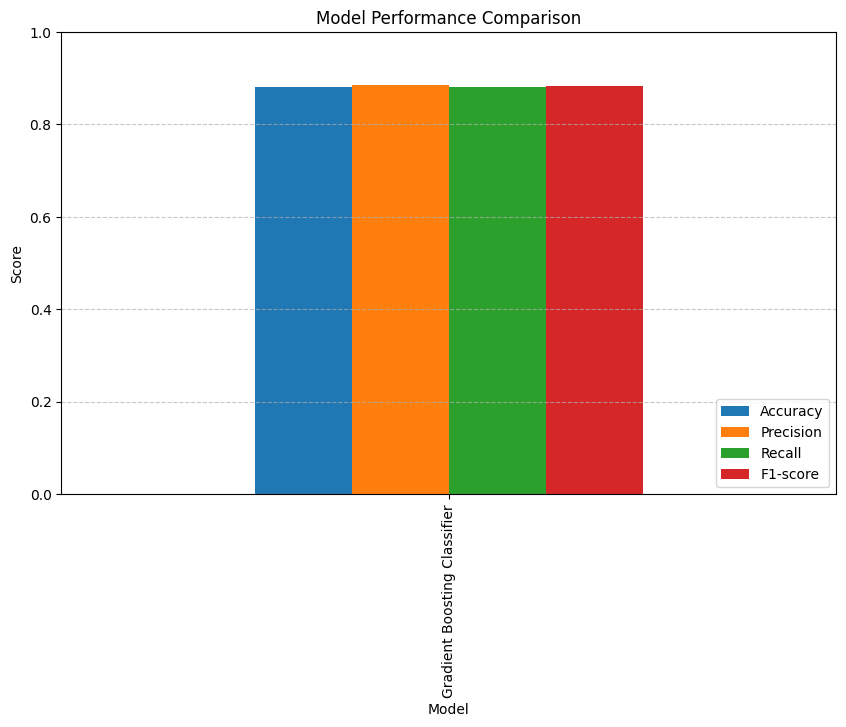

In [69]:
gradient_boosting_metrics=fit_pipeline_predict_evaluate(HistGradientBoostingClassifier(max_iter=100, random_state=27), "Gradient Boosting Classifier")

<Figure size 1200x800 with 0 Axes>

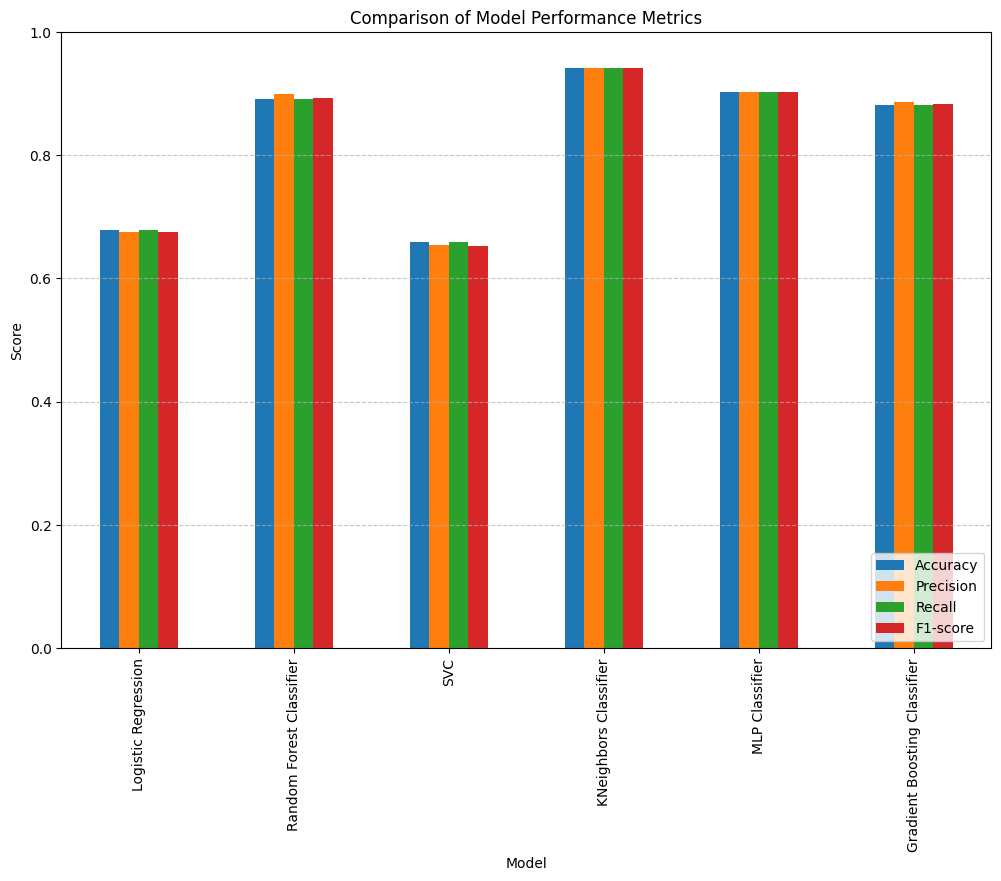

In [70]:
# Compare all metrics in one graph
def compare_all_metrics(logistic_metrics, rand_forest_metrics, svc_metrics, kneighbors_metrics, mlp_metrics, gradient_boosting_metrics):
    # Combine all metrics into a single DataFrame
    combined_metrics = pd.concat([logistic_metrics.set_index('Model'), 
                                   rand_forest_metrics.set_index('Model'), 
                                   svc_metrics.set_index('Model'), 
                                   kneighbors_metrics.set_index('Model'), 
                                   mlp_metrics.set_index('Model'), 
                                   gradient_boosting_metrics.set_index('Model')], axis=0)
    
    # Drop models that end with "pca" or "lda"
    combined_metrics = combined_metrics[~combined_metrics.index.str.endswith(('pca', 'lda'))]
    
    # Plot the combined metrics
    plt.figure(figsize=(12, 8))
    combined_metrics.plot(kind='bar', figsize=(12, 8))
    plt.title('Comparison of Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

compare_all_metrics(logistic_metrics, rand_forest_metrics, svc_metrics, kneighbors_metrics, mlp_metrics, gradient_boosting_metrics)

## Two Stage Models

In [71]:
def evaluate_layered_model(predicted_age_val,y_val, age_model_name, label=None):
    for gender in ['male_masculine', 'female_feminine', 'total']:
        if gender == 'total':
            gender_mask = y_val['gender'].notnull()  # Select all rows where gender is not null
        else:
            gender_mask = y_val['gender'] == gender
            
        y_true_gender = y_val.loc[gender_mask, 'age']
        y_pred_gender = [predicted_age_val[i] for i in range(len(predicted_age_val)) if gender_mask.iloc[i]]

        print(f"\n{age_model_name} -  Age Prediction Report for {gender}: {label}")
        print(classification_report(y_true_gender, y_pred_gender))

        cm_age_gender = confusion_matrix(y_true_gender, y_pred_gender)
        sns.heatmap(cm_age_gender, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Age Prediction for {gender}: {label}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()   

In [72]:
def fit_predict_gender_age_pipeline(gender_model_class, age_model_class_male, age_model_class_female, gender_model_name="GenderModel", age_model_name="AgeModel"):
    """
    Function to fit a gender classification pipeline and then train separate age prediction models by gender.
    Evaluates and visualizes the performance at each stage.
    """
    # Clone models
    gender_model = clone(gender_model_class)
    gender_model_pca = clone(gender_model_class)
    gender_model_lda = clone(gender_model_class)

    # Build gender prediction pipelines
    pipe_gender = make_pipeline(preprocessing, gender_model)
    pipe_gender_pca = make_pipeline(preprocessing_pca, gender_model_pca)
    pipe_gender_lda = make_pipeline(preprocessing_lda, gender_model_lda)

    # Fit gender classifiers
    pipe_gender.fit(X_train, y_train['gender'])
    pipe_gender_pca.fit(X_train, y_train['gender'])
    pipe_gender_lda.fit(X_train, y_train['gender'])

    # Evaluate gender predictions
    for name, pipe in zip(['Default', 'PCA', 'LDA'], [pipe_gender, pipe_gender_pca, pipe_gender_lda]):
        for split_name, X, y in [('Training', X_train, y_train), ('Validation', X_val, y_val)]:
            preds = pipe.predict(X)
            print(f"\n{name} Gender Model - {split_name} Set:")
            print(classification_report(y['gender'], preds))

            if split_name == 'Validation':
                cm = confusion_matrix(y['gender'], preds)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix - Gender ({name}, {split_name} Set)')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()

    # Use the default pipeline for gender predictions
    predicted_gender_val = pipe_gender.predict(X_val)

    # Train separate age models on true gender-labeled training data
    X_train_male = X_train[y_train['gender'] == 'male_masculine']
    y_train_male = y_train.loc[y_train['gender'] == 'male_masculine', 'age']
    X_train_female = X_train[y_train['gender'] == 'female_feminine']
    y_train_female = y_train.loc[y_train['gender'] == 'female_feminine', 'age']

    pipe_age_male = make_pipeline(preprocessing, clone(age_model_class_male))
    pipe_age_female = make_pipeline(preprocessing, clone(age_model_class_female))

    pipe_age_male.fit(X_train_male, y_train_male)
    pipe_age_female.fit(X_train_female, y_train_female)

    # Predict age on validation set using predicted gender
    predicted_age_val = []
    for i, gender in enumerate(predicted_gender_val):
        x_instance = X_val.iloc[[i]]  # preserve column names
        if gender == 'male_masculine':
            predicted_age_val.append(pipe_age_male.predict(x_instance)[0])
        else:
            predicted_age_val.append(pipe_age_female.predict(x_instance)[0])
    
    evaluate_layered_model(predicted_age_val, y_val, age_model_name, "Validation Set")


In [78]:
def fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class,
    age_model_class_male,
    age_model_class_female,
    gender_model_name="GenderModel",
    age_model_name="AgeModel"):

    # ====== Build models ======
    gender_model = clone(gender_model_class)
    
    # ====== Fit gender model ======
    pipe_gender = make_pipeline(preprocessing, gender_model)
    pipe_gender.fit(X_train, y_train['gender'])

    predicted_gender_train=pipe_gender.predict(X_train)
    predicted_gender_val = pipe_gender.predict(X_val)
    for split_name, preds, y in [('Training', predicted_gender_train, y_train), ('Validation', predicted_gender_val, y_val)]:
            print(f"\n{gender_model_name} Gender Model - {split_name} Set:")
            print(classification_report(y['gender'], preds))

            if split_name == 'Validation':
                cm = confusion_matrix(y['gender'], preds)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix - Gender ({gender_model_name}, {split_name} Set)')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()

    # ====== Train age models ======
    # Split train set by gender
    X_train_male = X_train[y_train['gender'] == 'male_masculine']
    y_train_male = y_train.loc[y_train['gender'] == 'male_masculine', 'age']
    X_train_female = X_train[y_train['gender'] == 'female_feminine']
    y_train_female = y_train.loc[y_train['gender'] == 'female_feminine', 'age']

    # Fit individual age models
    
    pipe_age_male = make_pipeline(preprocessing, clone(age_model_class_male))
    pipe_age_female = make_pipeline(preprocessing, clone(age_model_class_female))

    print(f"\nFitting {age_model_name} male")
    pipe_age_male.fit(X_train_male, y_train_male)
    print(f"\nFitting {age_model_name} female")
    pipe_age_female.fit(X_train_female, y_train_female)
    
    # ====== Age predictions ======
    predicted_age_true_gender = []
    predicted_age_pred_gender = []
    for i in tqdm(range(len(X_val)), desc=f"Predicting {age_model_name} on validation set"):
        x_instance = X_val.iloc[[i]]

        # TRUE gender routing
        true_gender = y_val.iloc[i]['gender']
        model_true = pipe_age_male if true_gender == 'male_masculine' else pipe_age_female
        predicted_age_true_gender.append(model_true.predict(x_instance)[0])

        # PREDICTED gender routing
        pred_gender = predicted_gender_val[i]
        model_pred = pipe_age_male if pred_gender == 'male_masculine' else pipe_age_female
        predicted_age_pred_gender.append(model_pred.predict(x_instance)[0])

    # ====== Evaluation ======

    evaluate_layered_model(predicted_age_true_gender, y_val, age_model_name, "Routed by True Gender")
    evaluate_layered_model(predicted_age_pred_gender, y_val, age_model_name, "Routed by Predicted Gender")

    # ====== Routing error cost ======
    acc_true = accuracy_score(y_val['age'], predicted_age_true_gender)
    acc_pred = accuracy_score(y_val['age'], predicted_age_pred_gender)
    routing_cost = acc_true - acc_pred
    print(f"\n🔍 Routing Error Cost (Accuracy Loss from using predicted gender): {routing_cost:.4f}")

    return {
        "acc_true_gender": acc_true,
        "acc_pred_gender": acc_pred,
        "routing_error_cost": routing_cost
    }



LogisticRegression Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.96      0.95      0.95     26265
 male_masculine       0.95      0.96      0.96     28405

       accuracy                           0.95     54670
      macro avg       0.95      0.95      0.95     54670
   weighted avg       0.95      0.95      0.95     54670


LogisticRegression Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.95      0.95      0.95      5630
 male_masculine       0.95      0.96      0.96      6086

       accuracy                           0.95     11716
      macro avg       0.95      0.95      0.95     11716
   weighted avg       0.95      0.95      0.95     11716



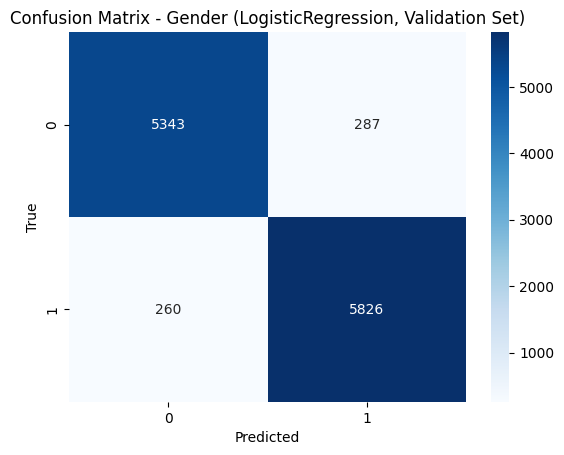


KNN_by_gender -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.85      0.76      0.80       644
        20.0       0.88      0.83      0.86      1413
        30.0       0.85      0.94      0.89      1378
        40.0       0.91      0.86      0.89       850
        50.0       0.89      0.96      0.92       985
        60.0       0.99      0.96      0.98       694
        70.0       0.99      0.98      0.98       122

    accuracy                           0.89      6086
   macro avg       0.91      0.90      0.90      6086
weighted avg       0.89      0.89      0.89      6086



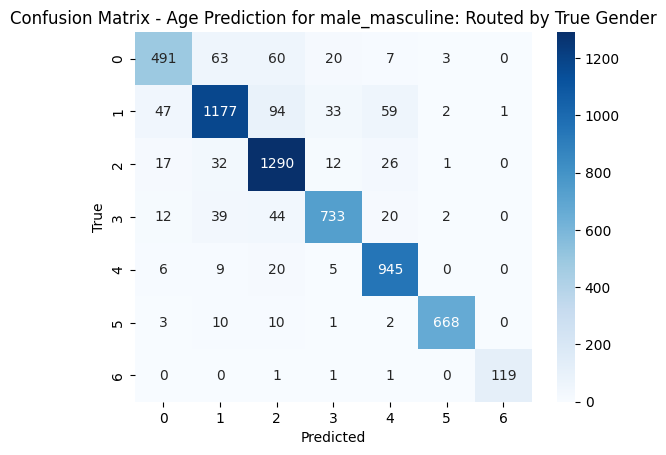


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.94      0.98      0.96       846
        20.0       0.98      0.91      0.94      1332
        30.0       0.95      0.98      0.96      1314
        40.0       0.99      1.00      0.99      1125
        50.0       0.97      0.96      0.97       383
        60.0       0.97      0.99      0.98       610
        70.0       1.00      0.95      0.97        20

    accuracy                           0.97      5630
   macro avg       0.97      0.97      0.97      5630
weighted avg       0.97      0.97      0.97      5630



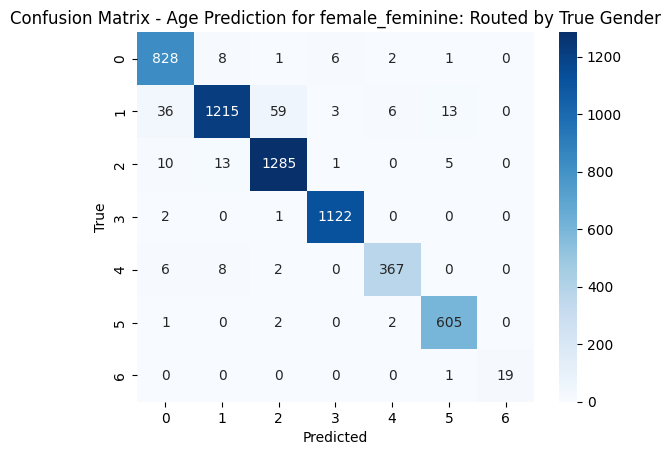


KNN_by_gender -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.90      0.89      0.89      1490
        20.0       0.93      0.87      0.90      2745
        30.0       0.90      0.96      0.93      2692
        40.0       0.96      0.94      0.95      1975
        50.0       0.91      0.96      0.94      1368
        60.0       0.98      0.98      0.98      1304
        70.0       0.99      0.97      0.98       142

    accuracy                           0.93     11716
   macro avg       0.94      0.94      0.94     11716
weighted avg       0.93      0.93      0.93     11716



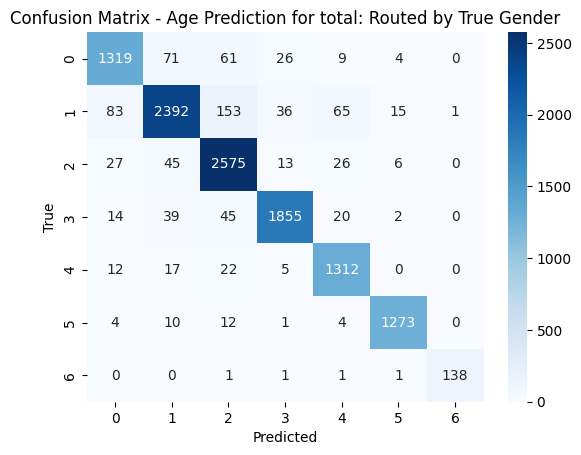


KNN_by_gender -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.82      0.73      0.77       644
        20.0       0.88      0.80      0.84      1413
        30.0       0.82      0.92      0.87      1378
        40.0       0.90      0.84      0.87       850
        50.0       0.88      0.96      0.92       985
        60.0       0.96      0.96      0.96       694
        70.0       0.99      0.93      0.96       122

    accuracy                           0.87      6086
   macro avg       0.89      0.88      0.88      6086
weighted avg       0.87      0.87      0.87      6086



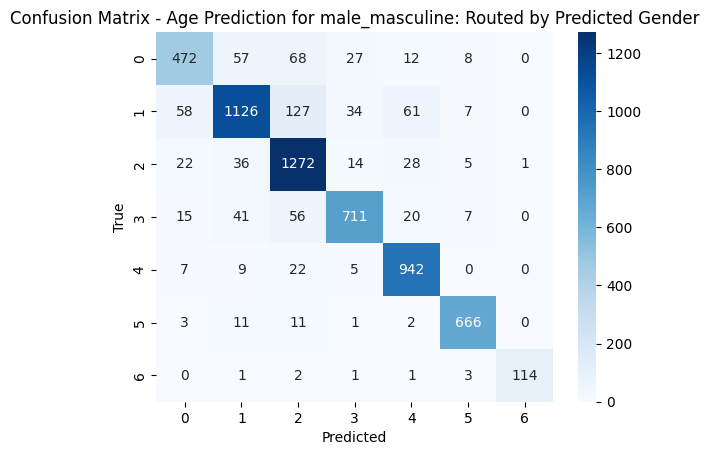


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.91      0.92      0.92       846
        20.0       0.93      0.87      0.90      1332
        30.0       0.90      0.96      0.93      1314
        40.0       0.96      0.98      0.97      1125
        50.0       0.91      0.87      0.89       383
        60.0       0.95      0.95      0.95       610
        70.0       1.00      0.65      0.79        20

    accuracy                           0.93      5630
   macro avg       0.94      0.89      0.91      5630
weighted avg       0.93      0.93      0.93      5630



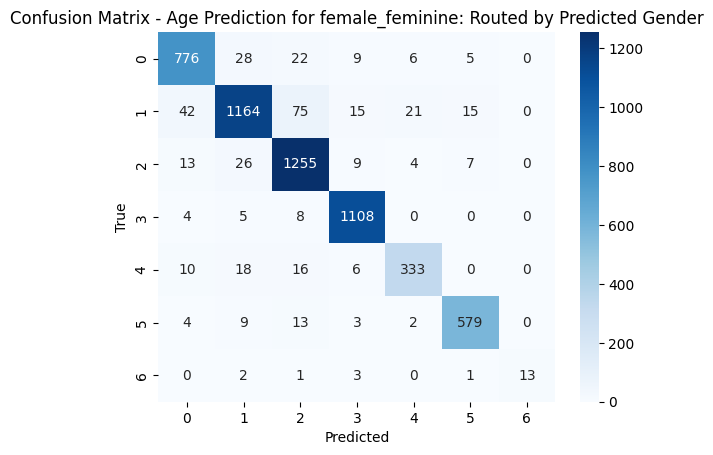


KNN_by_gender -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.88      0.84      0.86      1490
        20.0       0.90      0.83      0.87      2745
        30.0       0.86      0.94      0.90      2692
        40.0       0.93      0.92      0.93      1975
        50.0       0.89      0.93      0.91      1368
        60.0       0.96      0.95      0.96      1304
        70.0       0.99      0.89      0.94       142

    accuracy                           0.90     11716
   macro avg       0.92      0.90      0.91     11716
weighted avg       0.90      0.90      0.90     11716



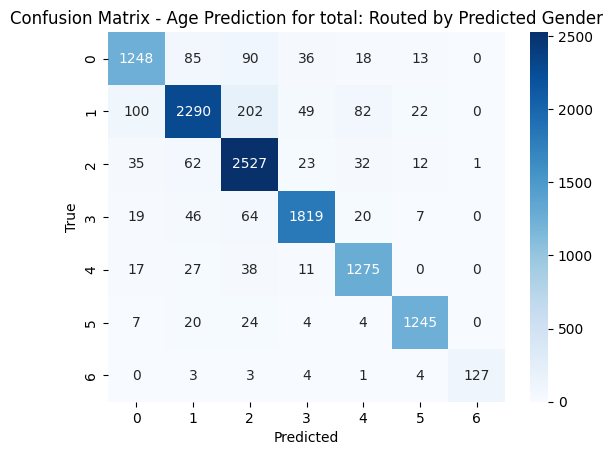


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0284


{'acc_true_gender': 0.9272789347900308,
 'acc_pred_gender': 0.8988562649368385,
 'routing_error_cost': 0.028422669853192306}

In [74]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=LogisticRegression(max_iter=1000),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="LogisticRegression",
    age_model_name="KNN_by_gender"
) """

fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=LogisticRegression(max_iter=1000),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="LogisticRegression",
    age_model_name="KNN_by_gender"
)



KNN_by_age Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.99      0.99      0.99     26265
 male_masculine       0.99      0.99      0.99     28405

       accuracy                           0.99     54670
      macro avg       0.99      0.99      0.99     54670
   weighted avg       0.99      0.99      0.99     54670


KNN_by_age Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.99      0.99      0.99      5630
 male_masculine       0.99      0.99      0.99      6086

       accuracy                           0.99     11716
      macro avg       0.99      0.99      0.99     11716
   weighted avg       0.99      0.99      0.99     11716



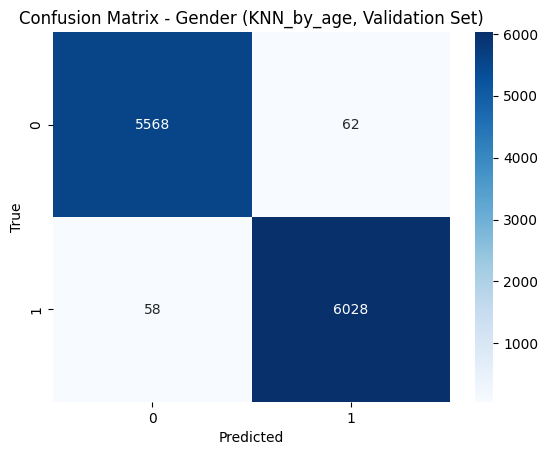


KNN_by_gender -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.85      0.76      0.80       644
        20.0       0.88      0.83      0.86      1413
        30.0       0.85      0.94      0.89      1378
        40.0       0.91      0.86      0.89       850
        50.0       0.89      0.96      0.92       985
        60.0       0.99      0.96      0.98       694
        70.0       0.99      0.98      0.98       122

    accuracy                           0.89      6086
   macro avg       0.91      0.90      0.90      6086
weighted avg       0.89      0.89      0.89      6086



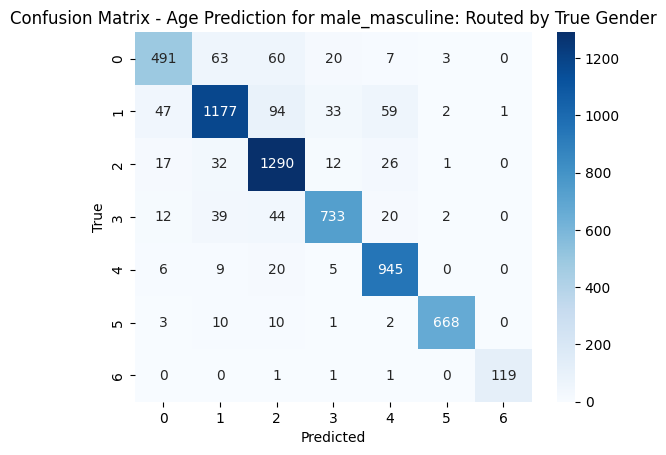


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.94      0.98      0.96       846
        20.0       0.98      0.91      0.94      1332
        30.0       0.95      0.98      0.96      1314
        40.0       0.99      1.00      0.99      1125
        50.0       0.97      0.96      0.97       383
        60.0       0.97      0.99      0.98       610
        70.0       1.00      0.95      0.97        20

    accuracy                           0.97      5630
   macro avg       0.97      0.97      0.97      5630
weighted avg       0.97      0.97      0.97      5630



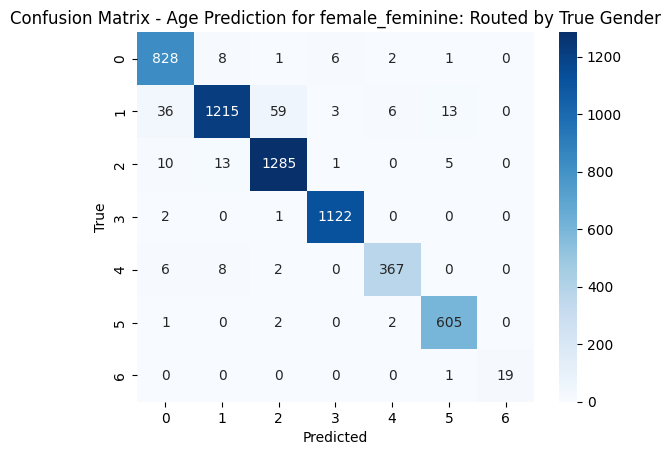


KNN_by_gender -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.90      0.89      0.89      1490
        20.0       0.93      0.87      0.90      2745
        30.0       0.90      0.96      0.93      2692
        40.0       0.96      0.94      0.95      1975
        50.0       0.91      0.96      0.94      1368
        60.0       0.98      0.98      0.98      1304
        70.0       0.99      0.97      0.98       142

    accuracy                           0.93     11716
   macro avg       0.94      0.94      0.94     11716
weighted avg       0.93      0.93      0.93     11716



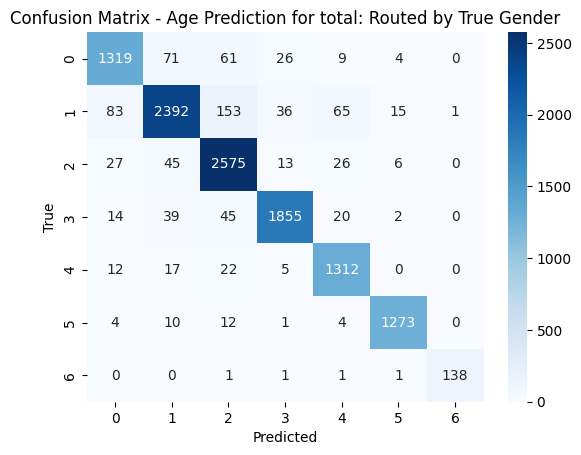


KNN_by_gender -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.85      0.76      0.80       644
        20.0       0.89      0.83      0.86      1413
        30.0       0.85      0.93      0.89      1378
        40.0       0.91      0.86      0.89       850
        50.0       0.89      0.96      0.92       985
        60.0       0.97      0.96      0.97       694
        70.0       0.99      0.98      0.98       122

    accuracy                           0.89      6086
   macro avg       0.91      0.90      0.90      6086
weighted avg       0.89      0.89      0.89      6086



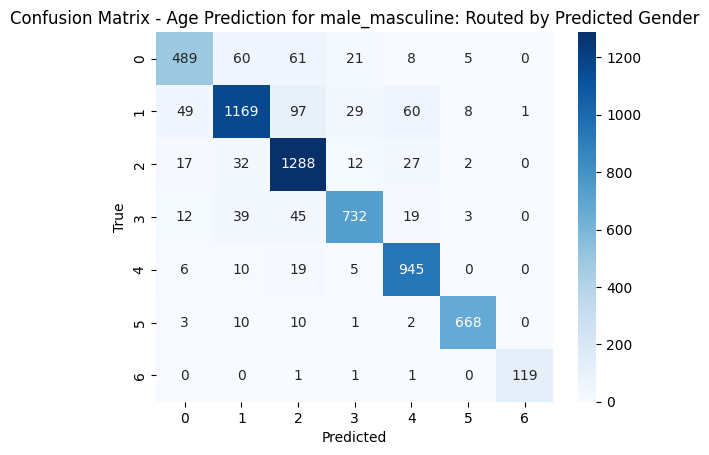


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.94      0.97      0.96       846
        20.0       0.97      0.90      0.94      1332
        30.0       0.94      0.97      0.96      1314
        40.0       0.98      0.99      0.99      1125
        50.0       0.96      0.95      0.95       383
        60.0       0.97      0.99      0.98       610
        70.0       1.00      0.95      0.97        20

    accuracy                           0.96      5630
   macro avg       0.97      0.96      0.96      5630
weighted avg       0.96      0.96      0.96      5630



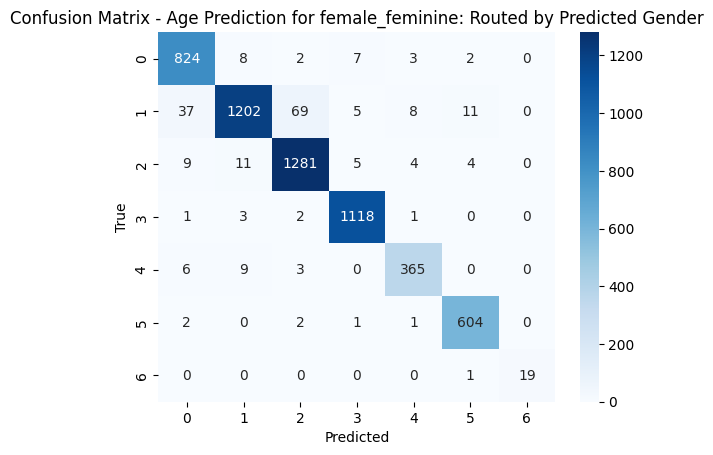


KNN_by_gender -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.90      0.88      0.89      1490
        20.0       0.93      0.86      0.90      2745
        30.0       0.89      0.95      0.92      2692
        40.0       0.96      0.94      0.95      1975
        50.0       0.91      0.96      0.93      1368
        60.0       0.97      0.98      0.97      1304
        70.0       0.99      0.97      0.98       142

    accuracy                           0.92     11716
   macro avg       0.94      0.93      0.93     11716
weighted avg       0.92      0.92      0.92     11716



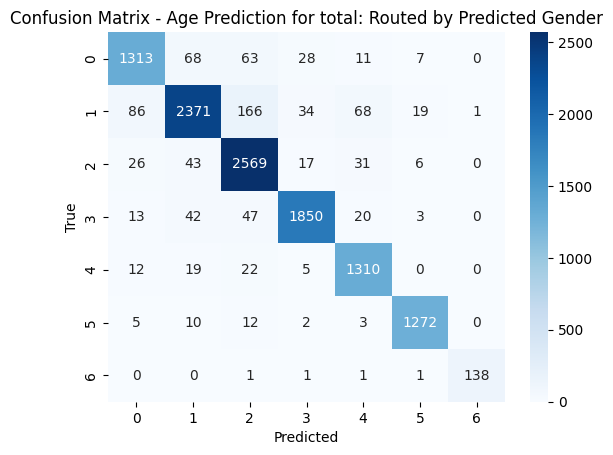


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0035


{'acc_true_gender': 0.9272789347900308,
 'acc_pred_gender': 0.9237794469102083,
 'routing_error_cost': 0.0034994878798224605}

In [75]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="KNN_by_age",
    age_model_name="KNN_by_gender"
) """

fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="KNN_by_age",
    age_model_name="KNN_by_gender"
) 


RandomForest Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       1.00      1.00      1.00     26265
 male_masculine       1.00      1.00      1.00     28405

       accuracy                           1.00     54670
      macro avg       1.00      1.00      1.00     54670
   weighted avg       1.00      1.00      1.00     54670


RandomForest Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.97      0.96      0.96      5630
 male_masculine       0.96      0.97      0.97      6086

       accuracy                           0.97     11716
      macro avg       0.97      0.97      0.97     11716
   weighted avg       0.97      0.97      0.97     11716



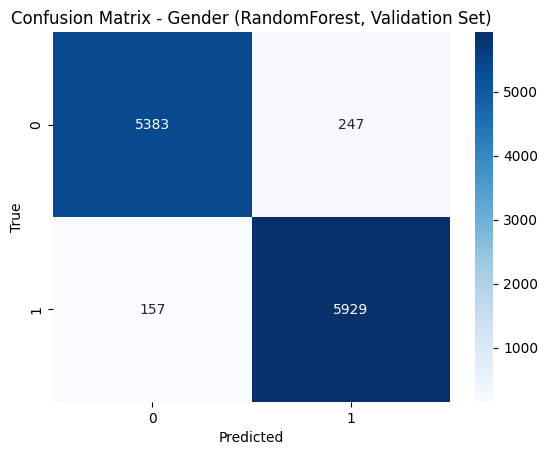


RandomForest -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.98      0.20      0.33       644
        20.0       0.60      0.84      0.70      1413
        30.0       0.71      0.87      0.78      1378
        40.0       0.89      0.63      0.74       850
        50.0       0.91      0.87      0.89       985
        60.0       0.99      0.93      0.96       694
        70.0       1.00      0.92      0.96       122

    accuracy                           0.77      6086
   macro avg       0.87      0.75      0.77      6086
weighted avg       0.81      0.77      0.75      6086



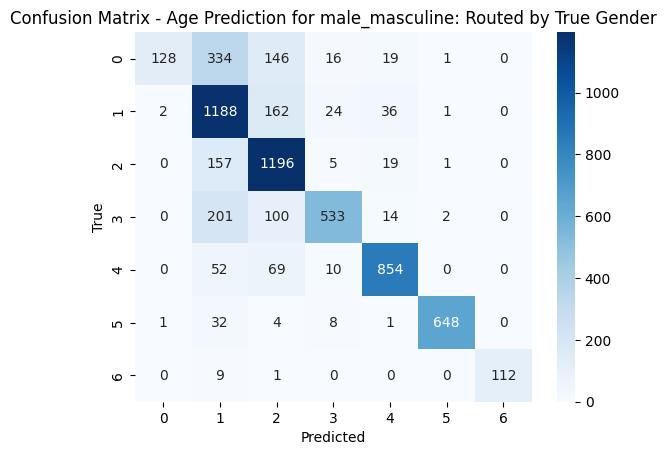


RandomForest -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.83      0.92      0.88       846
        20.0       0.87      0.89      0.88      1332
        30.0       0.94      0.94      0.94      1314
        40.0       0.99      0.95      0.97      1125
        50.0       0.97      0.85      0.91       383
        60.0       0.98      0.96      0.97       610
        70.0       1.00      0.85      0.92        20

    accuracy                           0.92      5630
   macro avg       0.94      0.91      0.92      5630
weighted avg       0.93      0.92      0.92      5630



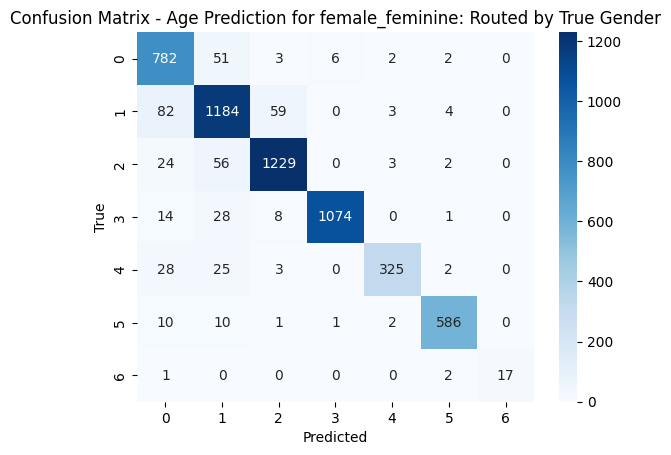


RandomForest -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.85      0.61      0.71      1490
        20.0       0.71      0.86      0.78      2745
        30.0       0.81      0.90      0.85      2692
        40.0       0.96      0.81      0.88      1975
        50.0       0.92      0.86      0.89      1368
        60.0       0.99      0.95      0.97      1304
        70.0       1.00      0.91      0.95       142

    accuracy                           0.84     11716
   macro avg       0.89      0.84      0.86     11716
weighted avg       0.85      0.84      0.84     11716



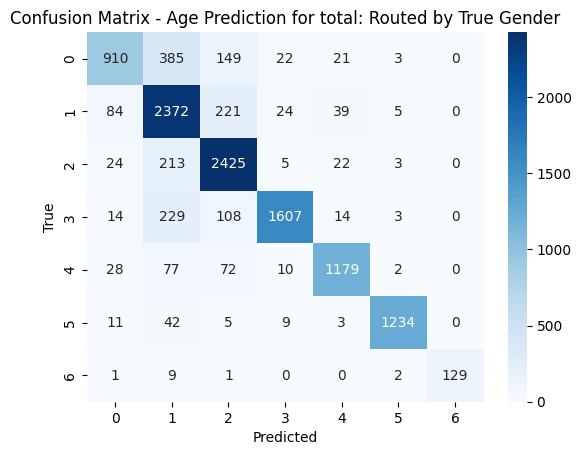


RandomForest -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.88      0.24      0.38       644
        20.0       0.60      0.83      0.70      1413
        30.0       0.72      0.86      0.78      1378
        40.0       0.90      0.62      0.74       850
        50.0       0.91      0.87      0.89       985
        60.0       0.98      0.93      0.96       694
        70.0       1.00      0.92      0.96       122

    accuracy                           0.77      6086
   macro avg       0.85      0.75      0.77      6086
weighted avg       0.80      0.77      0.75      6086



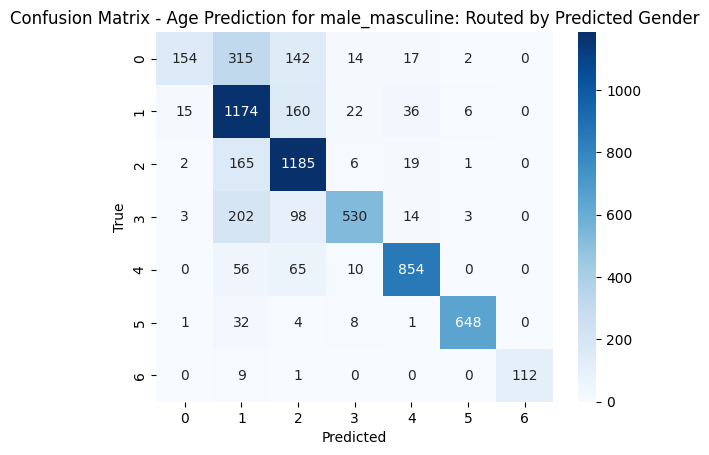


RandomForest -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.84      0.88      0.86       846
        20.0       0.82      0.86      0.84      1332
        30.0       0.91      0.92      0.92      1314
        40.0       0.97      0.95      0.96      1125
        50.0       0.95      0.80      0.87       383
        60.0       0.98      0.92      0.95       610
        70.0       1.00      0.70      0.82        20

    accuracy                           0.90      5630
   macro avg       0.93      0.86      0.89      5630
weighted avg       0.90      0.90      0.90      5630



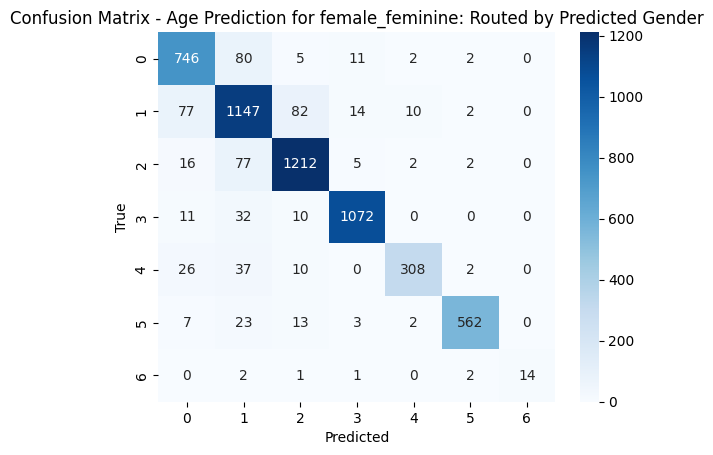


RandomForest -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.85      0.60      0.71      1490
        20.0       0.69      0.85      0.76      2745
        30.0       0.80      0.89      0.84      2692
        40.0       0.94      0.81      0.87      1975
        50.0       0.92      0.85      0.88      1368
        60.0       0.98      0.93      0.95      1304
        70.0       1.00      0.89      0.94       142

    accuracy                           0.83     11716
   macro avg       0.88      0.83      0.85     11716
weighted avg       0.84      0.83      0.83     11716



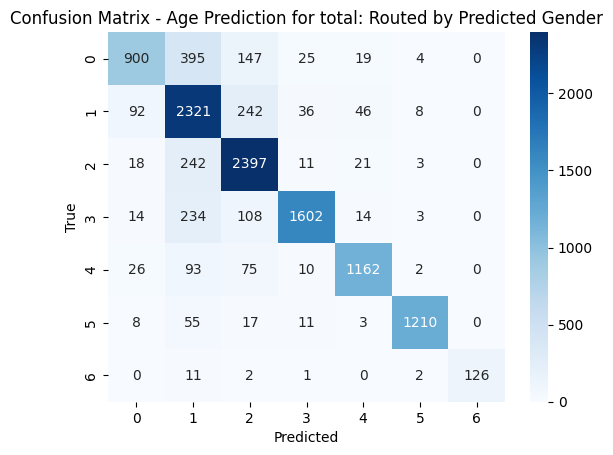


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0118


{'acc_true_gender': 0.8412427449641516,
 'acc_pred_gender': 0.8294639808808467,
 'routing_error_cost': 0.011778764083304916}

In [76]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    gender_model_name="RandomForest",
    age_model_name="RandomForest"
) """

fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=RandomForestClassifier(n_estimators=100, random_state=27),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27),
    gender_model_name="RandomForest",
    age_model_name="RandomForest"
)


KNN_by_age Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.99      0.99      0.99     26265
 male_masculine       0.99      0.99      0.99     28405

       accuracy                           0.99     54670
      macro avg       0.99      0.99      0.99     54670
   weighted avg       0.99      0.99      0.99     54670


KNN_by_age Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.99      0.99      0.99      5630
 male_masculine       0.99      0.99      0.99      6086

       accuracy                           0.99     11716
      macro avg       0.99      0.99      0.99     11716
   weighted avg       0.99      0.99      0.99     11716



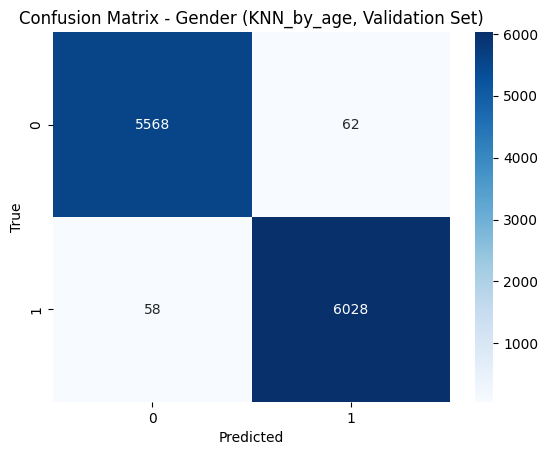


Fitting RandomForest male

Fitting RandomForest female


Predicting RandomForest on validation set: 100%|██████████| 11716/11716 [03:47<00:00, 51.40it/s]



RandomForest -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.93      0.27      0.42       644
        20.0       0.64      0.80      0.71      1413
        30.0       0.71      0.88      0.78      1378
        40.0       0.85      0.67      0.75       850
        50.0       0.87      0.86      0.87       985
        60.0       0.98      0.94      0.96       694
        70.0       0.99      0.85      0.92       122

    accuracy                           0.77      6086
   macro avg       0.85      0.75      0.77      6086
weighted avg       0.80      0.77      0.76      6086



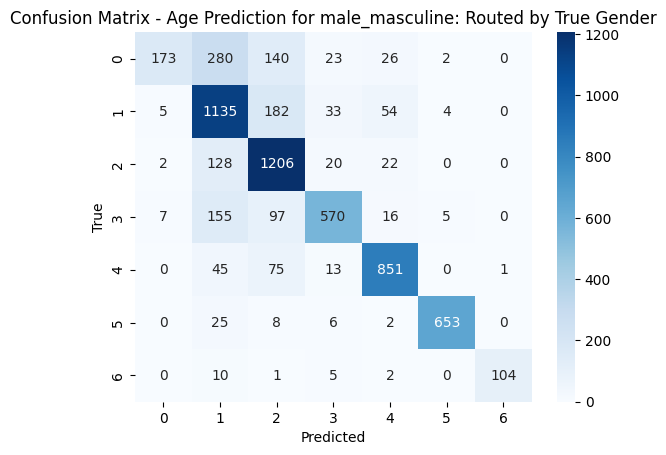


RandomForest -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.84      0.93      0.89       846
        20.0       0.87      0.90      0.88      1332
        30.0       0.94      0.92      0.93      1314
        40.0       1.00      0.96      0.98      1125
        50.0       0.97      0.85      0.91       383
        60.0       0.97      0.96      0.96       610
        70.0       1.00      0.85      0.92        20

    accuracy                           0.92      5630
   macro avg       0.94      0.91      0.92      5630
weighted avg       0.93      0.92      0.92      5630



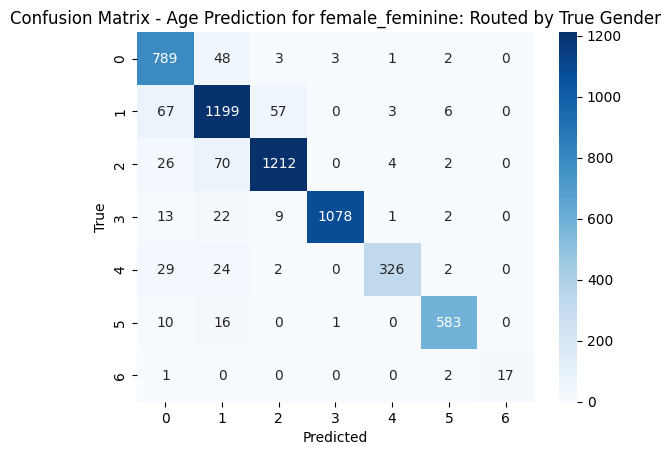


RandomForest -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.86      0.65      0.74      1490
        20.0       0.74      0.85      0.79      2745
        30.0       0.81      0.90      0.85      2692
        40.0       0.94      0.83      0.88      1975
        50.0       0.90      0.86      0.88      1368
        60.0       0.98      0.95      0.96      1304
        70.0       0.99      0.85      0.92       142

    accuracy                           0.84     11716
   macro avg       0.89      0.84      0.86     11716
weighted avg       0.85      0.84      0.84     11716



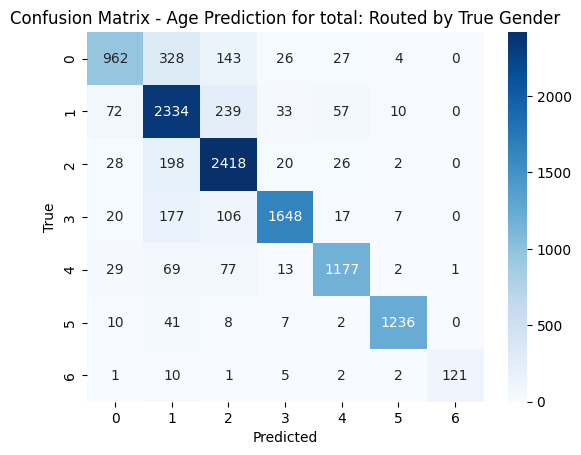


RandomForest -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.89      0.27      0.42       644
        20.0       0.64      0.80      0.71      1413
        30.0       0.71      0.87      0.78      1378
        40.0       0.85      0.67      0.75       850
        50.0       0.87      0.86      0.87       985
        60.0       0.98      0.94      0.96       694
        70.0       0.99      0.85      0.92       122

    accuracy                           0.77      6086
   macro avg       0.85      0.75      0.77      6086
weighted avg       0.79      0.77      0.76      6086



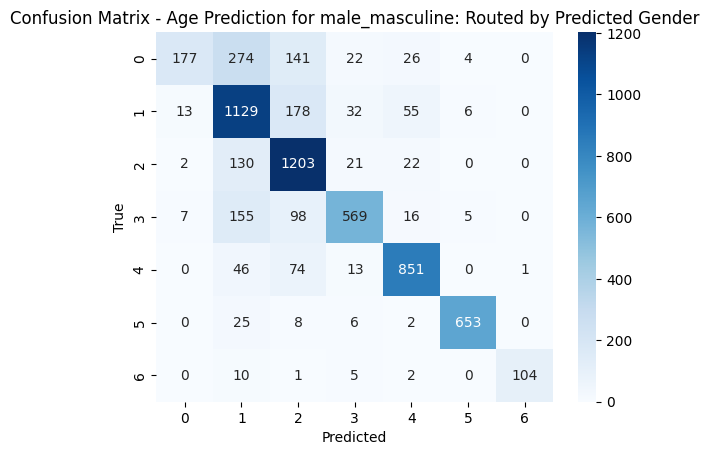


RandomForest -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.85      0.93      0.89       846
        20.0       0.87      0.90      0.88      1332
        30.0       0.94      0.93      0.93      1314
        40.0       0.99      0.96      0.97      1125
        50.0       0.97      0.85      0.91       383
        60.0       0.97      0.96      0.96       610
        70.0       1.00      0.85      0.92        20

    accuracy                           0.92      5630
   macro avg       0.94      0.91      0.92      5630
weighted avg       0.93      0.92      0.92      5630



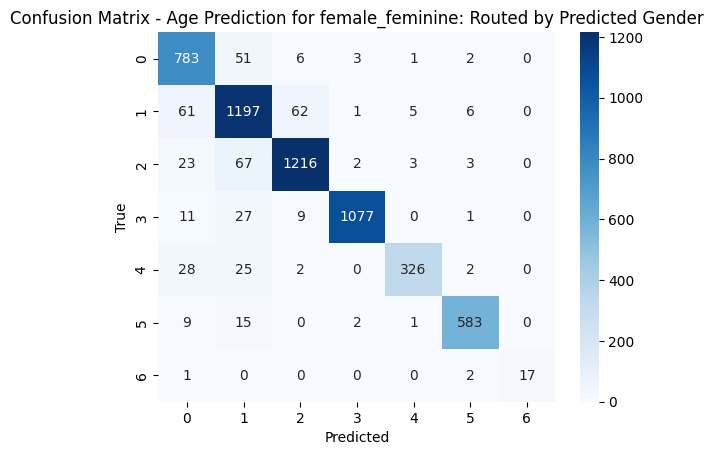


RandomForest -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.86      0.64      0.74      1490
        20.0       0.74      0.85      0.79      2745
        30.0       0.81      0.90      0.85      2692
        40.0       0.94      0.83      0.88      1975
        50.0       0.90      0.86      0.88      1368
        60.0       0.98      0.95      0.96      1304
        70.0       0.99      0.85      0.92       142

    accuracy                           0.84     11716
   macro avg       0.89      0.84      0.86     11716
weighted avg       0.85      0.84      0.84     11716



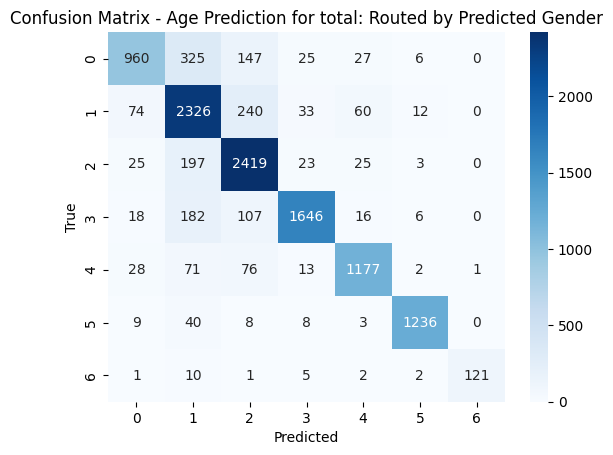


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0009


{'acc_true_gender': 0.8446568794810515,
 'acc_pred_gender': 0.8437179924889041,
 'routing_error_cost': 0.0009388869921473919}

In [81]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    gender_model_name="KNN_by_age",
    age_model_name="RandomForest"
) """


fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27),
    gender_model_name="KNN_by_age",
    age_model_name="RandomForest")